In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Read Excel Data

In [19]:
df_2023 = pd.read_excel("/kaggle/input/mumbai-aqi-data/Mumbai_AQI_2023.xlsx")
df_2022 = pd.read_excel("/kaggle/input/mumbai-aqi-data/Mumbai_AQI_2022.xlsx")
df_2020 = pd.read_excel("/kaggle/input/mumbai-aqi-data/Mumbai_AQI_2021.xlsx")
df_2021 = pd.read_excel("/kaggle/input/mumbai-aqi-data/Mumbai_AQI_2020.xlsx")
df_2019 = pd.read_excel("/kaggle/input/mumbai-aqi-data/Mumbai_AQI_2019.xlsx")
df_2018 = pd.read_excel("/kaggle/input/mumbai-aqi-data/Mumbai_AQI_2018.xlsx")
df_2017 = pd.read_excel("/kaggle/input/mumbai-aqi-data/Mumbai_AQI_2017.xlsx")

In [4]:
df_2023

Day  Jan    Feb  Mar    Apr  May   June  July  Aug  Sept  Oct    Nov  Dec
0     1  147  227.0  174  108.0   74   89.0    67   54  84.0   87  175.0  127
1     2  188  180.0  205   93.0   78   84.0    54   58  81.0   97  169.0  138
2     3  214  198.0  262   86.0   80   74.0    62   62  80.0  116  178.0  144
3     4  204  201.0  281   86.0   76   72.0    65   73  86.0  121  180.0  128
4     5  223  226.0  260   87.0   75   73.0    65   62  81.0  120  198.0  136
5     6  255  185.0  246   99.0   74   81.0    51   68  78.0  131  198.0  154
6     7  204  177.0  139  149.0   84   87.0    54   70  71.0  120  186.0  125
7     8  198  233.0  136  182.0   82   89.0    91   71  65.0  110  131.0  117
8     9  137  236.0  156  156.0   91   81.0    70   78  61.0  144  111.0  114
9    10  158  200.0  145  132.0  112   85.0    65   65  54.0  109   87.0  114
10   11  213  172.0  163  112.0  121   85.0    73   61  54.0   88   90.0  108
11   12  196  165.0  186  134.0  120   90.0    77   65  59.0  100  154.0  114
12   13  134  146.0  213  130.0   99   83.0   108   68  58.0  159  193.0  115
13   14  240  203.0  199  126.0   52   78.0    87   67  63.0  177  168.0  134
14   15  198  224.0  165  110.0   68   83.0    82   62  65.0  150  201.0  139
15   16  214  199.0  146  100.0   67   84.0    87   56  60.0  185  168.0  133
16   17  236  201.0  117   95.0   69   89.0    83   55  57.0  189  140.0  126
17   18  264  185.0  118  103.0   75   98.0    80   55  58.0  199  162.0  136
18   19  256  191.0   97  125.0   76   92.0    86   50  53.0  156  159.0  138
19   20  231  183.0   90  106.0   80   93.0    86   53  51.0  185  115.0  134
20   21  175  201.0   91   79.0   73  100.0    87   51  59.0  155  132.0  157
21   22  168  123.0   96   74.0   70   97.0    88   50  59.0  172  123.0  189
22   23  170  172.0   86   86.0   79   77.0    88   52  58.0  177  137.0  190
23   24  175  219.0   73   77.0   69   73.0    87   53  53.0  182  152.0  166
24   25  209  197.0   88  101.0   68   61.0    81   54  59.0  157  124.0  155
25   26  232  208.0   98   94.0   67   73.0    48   61  67.0  157   98.0  178
26   27  254  194.0   97   92.0   73   58.0    45   60  68.0  139   59.0  174
27   28  244  188.0  117   71.0   75   61.0    49   56  77.0  153   61.0  194
28   29  176    NaN  125   81.0   78   53.0    51   64  94.0  152   94.0  181
29   30  154    NaN  106   81.0   80   56.0    52   87  72.0  157  102.0  161
30   31  225    NaN   82    NaN   97    NaN    53   91   NaN  168    NaN  143

In [5]:
def format_dataframe(df):
  time_series_df = pd.melt(df, id_vars=['Day'], var_name='Month', value_name='AQI')
  time_series_df['AQI'].fillna(0, inplace=True)
  time_series_df['Month'] = pd.Categorical(time_series_df['Month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], ordered=True)
  time_series_df.sort_values(by=['Month', 'Day'], inplace=True)
  time_series_df.reset_index(drop=True, inplace=True)
  return time_series_dfdf = df_2023

In [11]:
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'June': 6, 'July': 7, 'Aug': 8,
    'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

def format_dataframe(df):
  time_series_df = pd.melt(df, id_vars=['Day'], var_name='Month', value_name='AQI')
  time_series_df['AQI'].fillna(0, inplace=True)
  time_series_df['Month'] = pd.Categorical(time_series_df['Month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], ordered=True)
  time_series_df.sort_values(by=['Month', 'Day'], inplace=True)
  time_series_df.reset_index(drop=True, inplace=True)
  return time_series_df

def create_timestamp(row):
    month = month_map[row['Month']]
    day = int(row['Day'])
    try:
        return pd.Timestamp(year=2023, month=month, day=day)
    except ValueError:
        return pd.Timestamp(year=2023, month=month, day=1) + pd.offsets.MonthEnd(0)

def format_timestamp(df):
  df['TimeStamp'] = df.apply(create_timestamp, axis=1)
  df.set_index('TimeStamp', inplace=True)
  df.drop(columns=['Day', 'Month'], inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  return df

In [12]:
df_2023 = format_dataframe(df_2023)
df_2023 = format_timestamp(df_2023)

/tmp/ipykernel_33/1142292228.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  time_series_df['AQI'].fillna(0, inplace=True)


<Axes: xlabel='TimeStamp'>

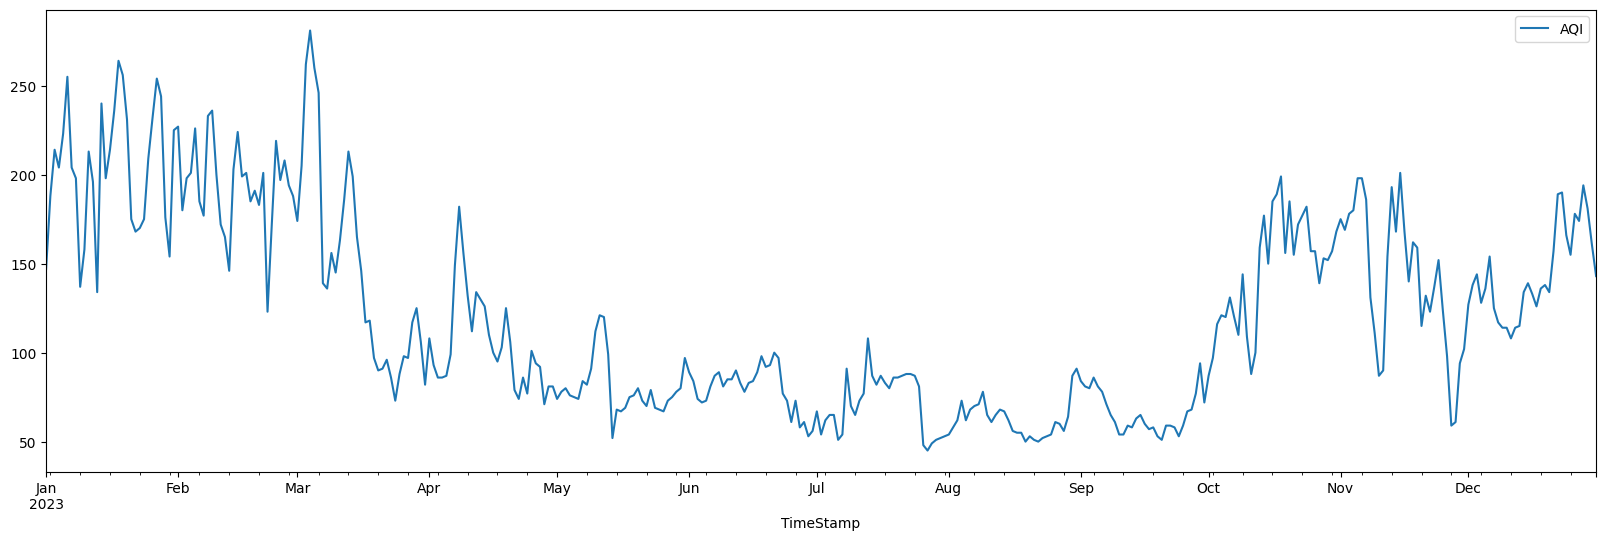

In [13]:
df_2023.plot(figsize=(20, 6))

In [15]:
def create_timestamp(row):
    try:
        return pd.Timestamp(year=year, month=month_map[row['Month']], day=int(row['Date']))
    except ValueError:
        return pd.NaT  # Return NaT (Not a Time) for invalid date values
    
def format(df):
    melted_df = pd.melt(df, id_vars=['Date'], var_name='Month', value_name='AQI')
    melted_df['TimeStamp'] = melted_df.apply(create_timestamp, axis=1)
    melted_df.dropna(subset=['TimeStamp'], inplace=True)
    melted_df.set_index('TimeStamp', inplace=True)
    melted_df.drop(columns=['Date', 'Month'], inplace=True)
    return melted_df

In [20]:
df_2022.head()

Date  January  February  March  April  May   June  July  August  September  \
0     1      173     177.0    187  196.0   89   79.0    58      65       64.0   
1     2      150     179.0    216  214.0  103   99.0    67      63       74.0   
2     3      156     187.0    204  172.0   91  108.0    72      89       80.0   
3     4      184     162.0    177  142.0  103   77.0    65      61       69.0   
4     5      219     276.0    167  108.0  118   69.0    60      71       60.0   

   October  November  December  
0       78     152.0       213  
1       58     169.0       216  
2       58     141.0       219  
3       70     145.0       249  
4       75     159.0       272

<Axes: xlabel='TimeStamp'>

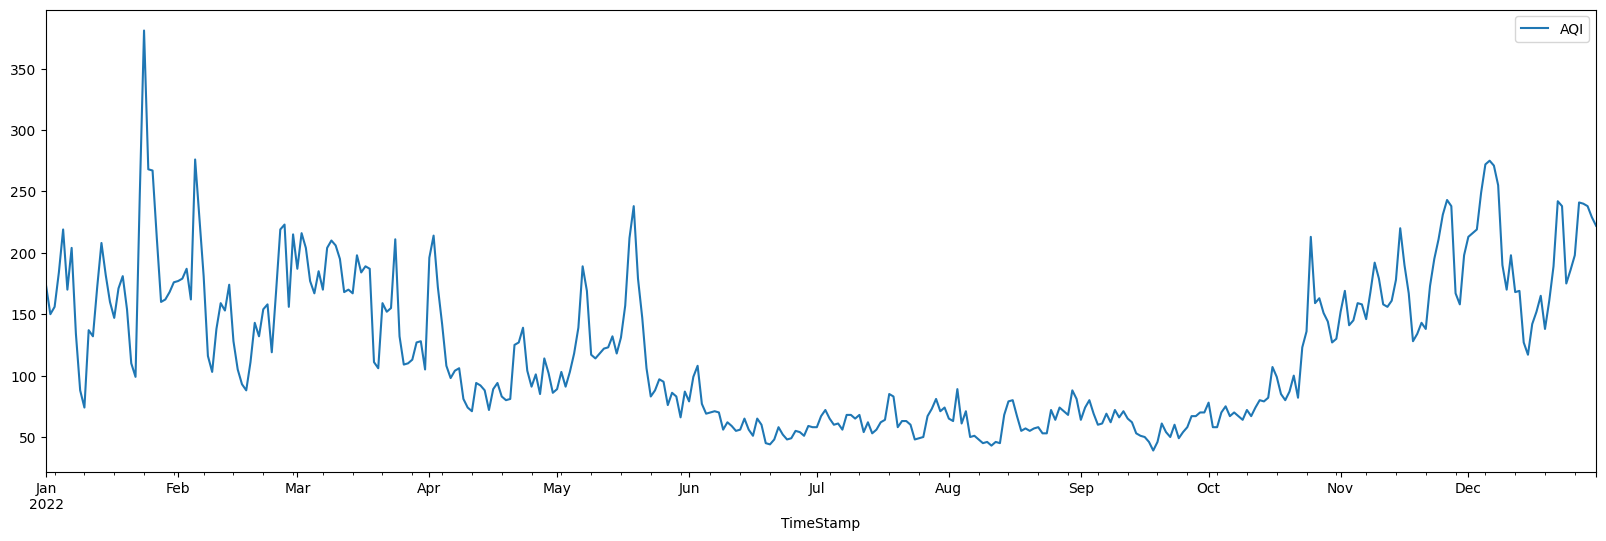

In [21]:
df_2022.columns= ['Date', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
year = 2022
df_2022 = format(df_2022)
df_2022.plot(figsize=(20, 6))

In [23]:
df_2021.head()

Date  January  February  March  April  May  June  July  August  September  \
0     1      198     164.0    107   57.0   51  34.0    31      34       36.0   
1     2      243     179.0    122   72.0   43  46.0    29      27       47.0   
2     3      201     188.0    125   85.0   40  32.0    34      26       57.0   
3     4      221     176.0    117   81.0   37  36.0    28      25       69.0   
4     5      211     137.0    104   77.0   38  41.0    33      30       84.0   

   October  November  December  
0       75     111.0       152  
1       77     125.0       163  
2      100     194.0       170  
3       70     160.0       167  
4       55     163.0       185

<Axes: xlabel='TimeStamp'>

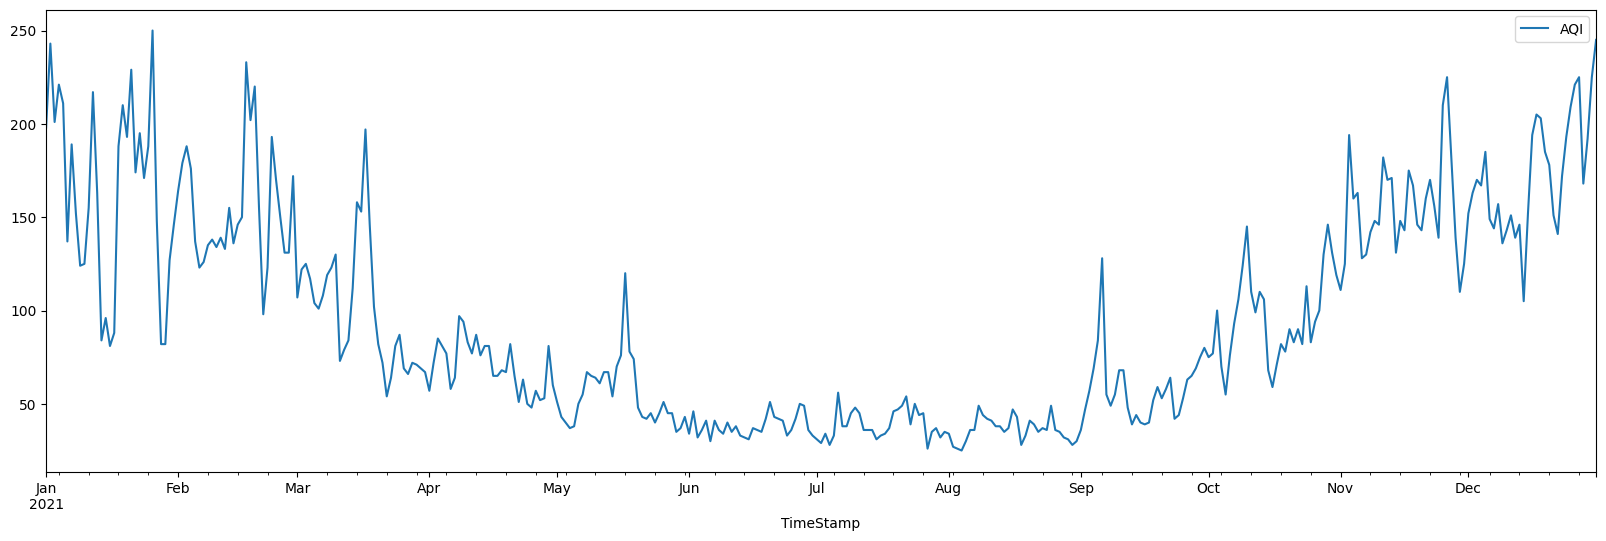

In [24]:
df_2021.columns= ['Date', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
year = 2021
df_2021 = format(df_2021)
df_2021.plot(figsize=(20, 6))

In [25]:
df_2020.head()

Date  January  February  March  April  May  June  July  August  September  \
0     1      244     184.0    161  113.0   68  61.0    70      63       54.0   
1     2      255     180.0    175  162.0   71  50.0    62      58       52.0   
2     3      251     188.0    142  139.0  105  53.0    60      50       53.0   
3     4      226     182.0    185  102.0   80  46.0    56      53       54.0   
4     5      234     182.0    211   90.0   76  51.0    64      55       53.0   

   October  November  December  
0       76     188.0       154  
1       77     211.0        78  
2       78     179.0        93  
3       78     164.0       116  
4       71     199.0       109

<Axes: xlabel='TimeStamp'>

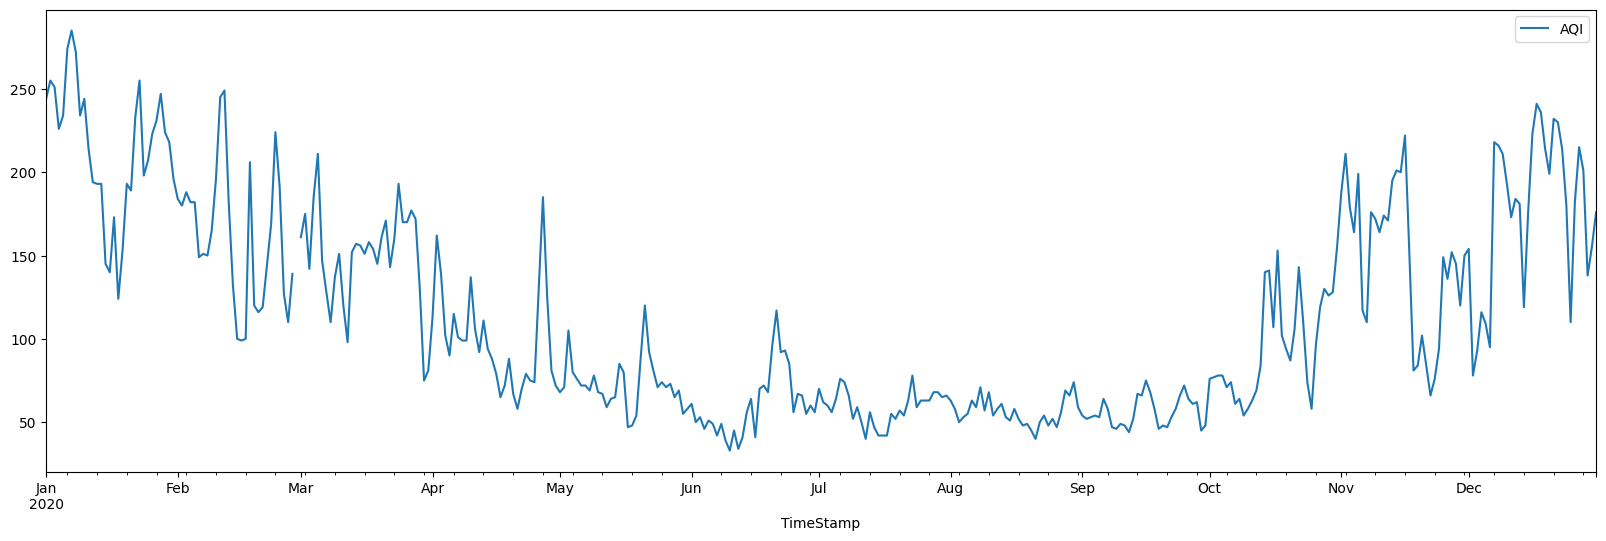

In [26]:
df_2020.columns= ['Date', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
year = 2020
df_2020 = format(df_2020)
df_2020.plot(figsize=(20, 6))

In [27]:
df_2019.head()

Date  January  February  March  April  May  June  July  August  September  \
0     1      194     153.0    NaN   90.0   88  79.0    42      46       43.0   
1     2      180     158.0  207.0    NaN  109  79.0    46      44       54.0   
2     3      267     204.0   84.0   99.0   90  78.0    41      37       39.0   
3     4      223     197.0   83.0   88.0   89  58.0    46      41       36.0   
4     5      178     159.0  113.0   91.0   88  59.0    55      44       36.0   

   October  November  December  
0       37      65.0       211  
1       60      43.0       151  
2       55      69.0       104  
3       62      71.0        92  
4       82      71.0       112

<Axes: xlabel='TimeStamp'>

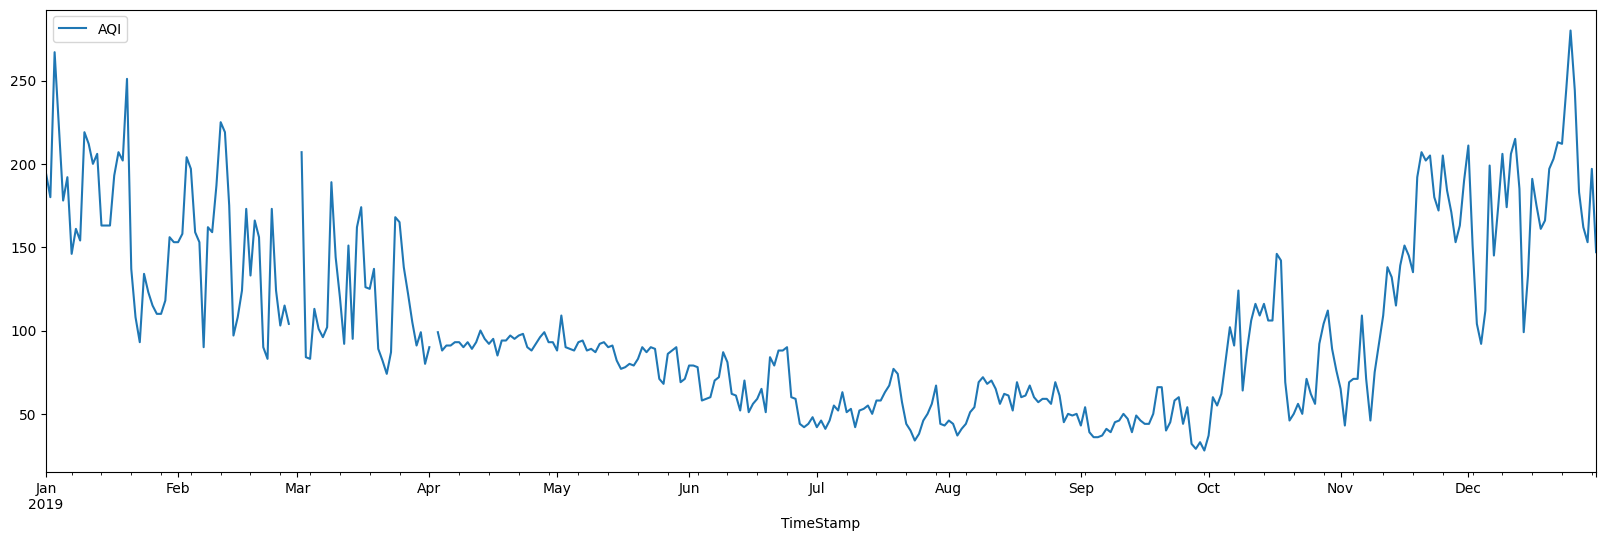

In [28]:
df_2019.columns= ['Date', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
year = 2019
df_2019 = format(df_2019)
df_2019.plot(figsize=(20, 6))

<Axes: xlabel='TimeStamp'>

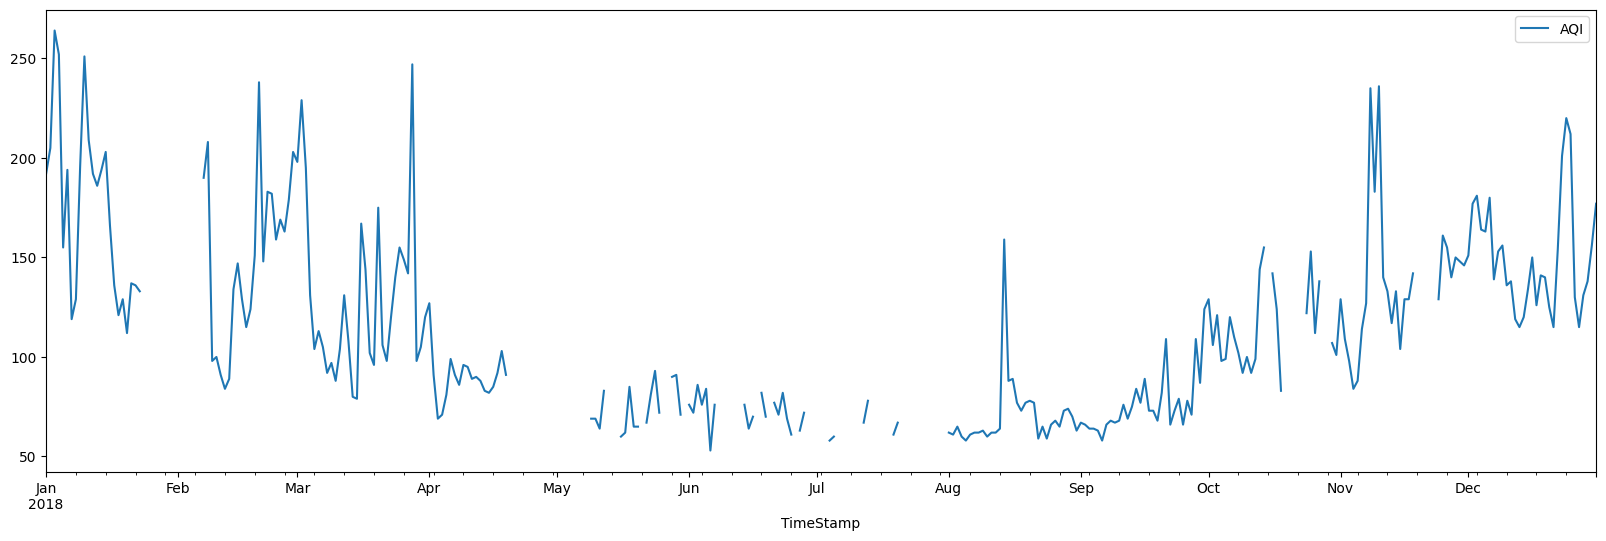

In [29]:
df_2018.columns= ['Date', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
year = 2018
df_2018 = format(df_2018)
df_2018.plot(figsize=(20, 6))

<Axes: xlabel='TimeStamp'>

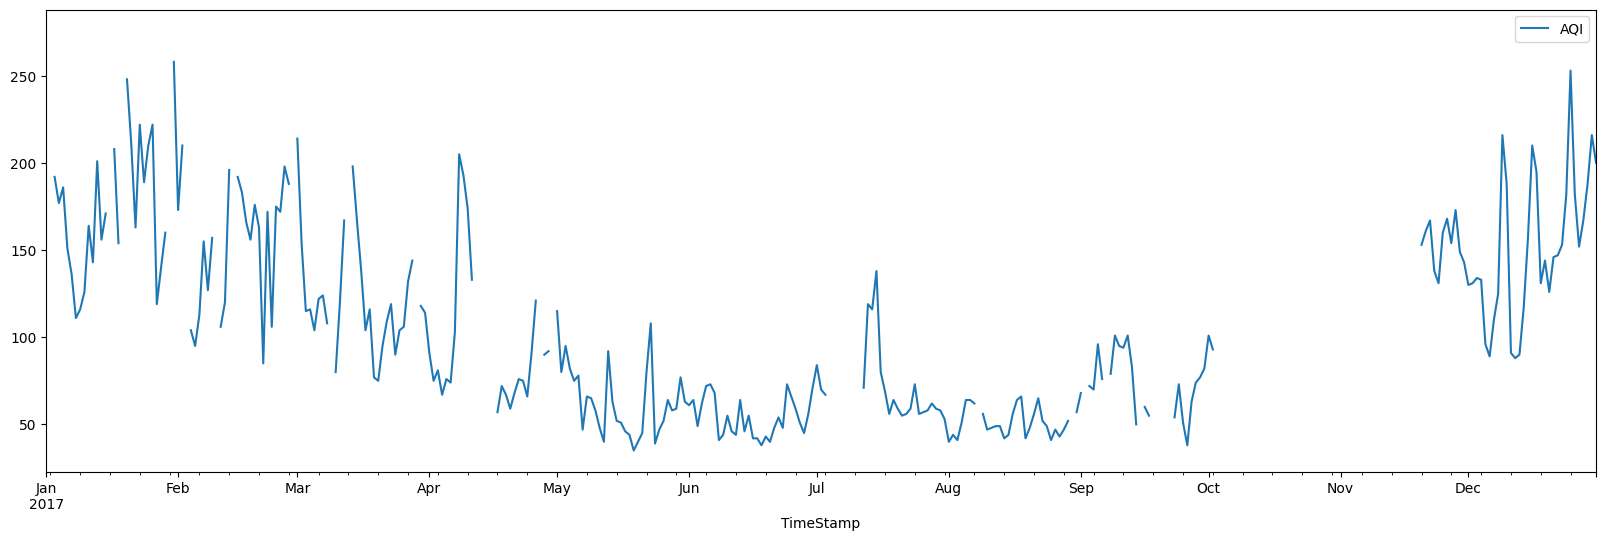

In [30]:
df_2017.columns= ['Date', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
year = 2017
df_2017 = format(df_2017)
df_2017.plot(figsize=(20, 6))

In [46]:
dfs = [df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]
combined_df = pd.concat(dfs)
combined_df.reset_index(inplace=True)
combined_df.set_index('TimeStamp', inplace=True)
combined_df.sort_index(inplace=True)
df = combined_df
df

AQI
TimeStamp        
2017-01-01  276.0
2017-01-02    NaN
2017-01-03  192.0
2017-01-04  177.0
2017-01-05  186.0
...           ...
2023-12-27  174.0
2023-12-28  194.0
2023-12-29  181.0
2023-12-30  161.0
2023-12-31  143.0

[2556 rows x 1 columns]

<Axes: xlabel='TimeStamp'>

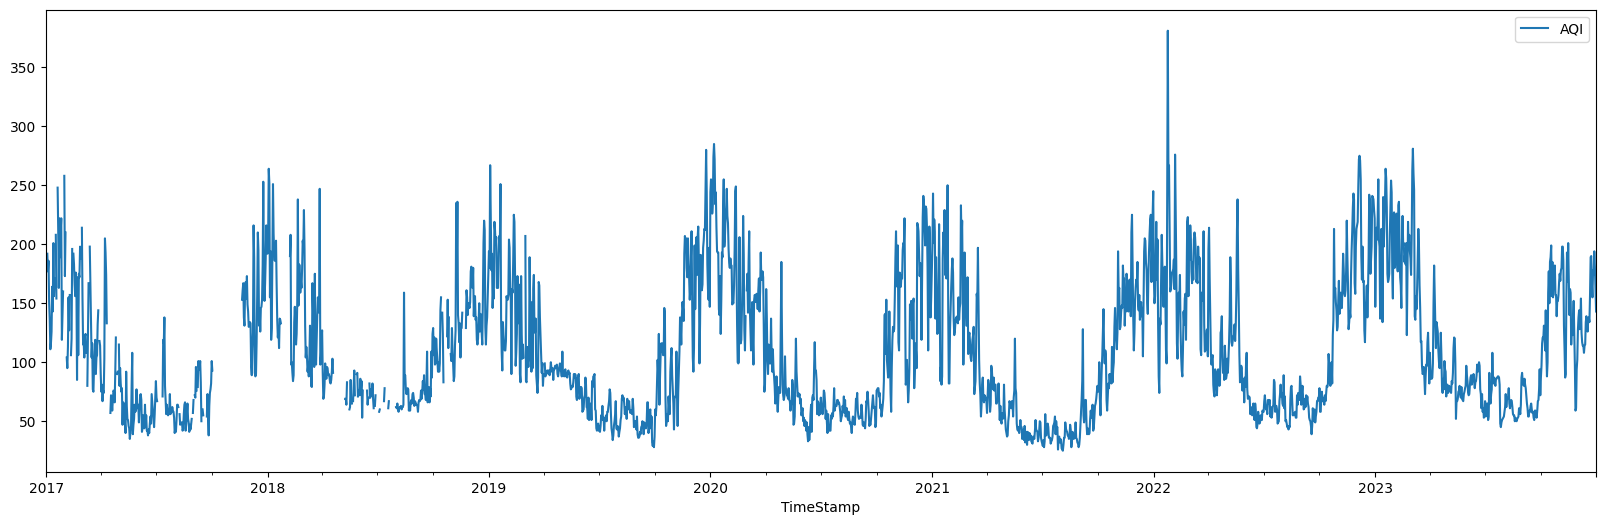

In [47]:
df.plot(figsize=(20, 6))

In [48]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

/tmp/ipykernel_33/3490755982.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/tmp/ipykernel_33/3490755982.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


<Axes: xlabel='TimeStamp'>

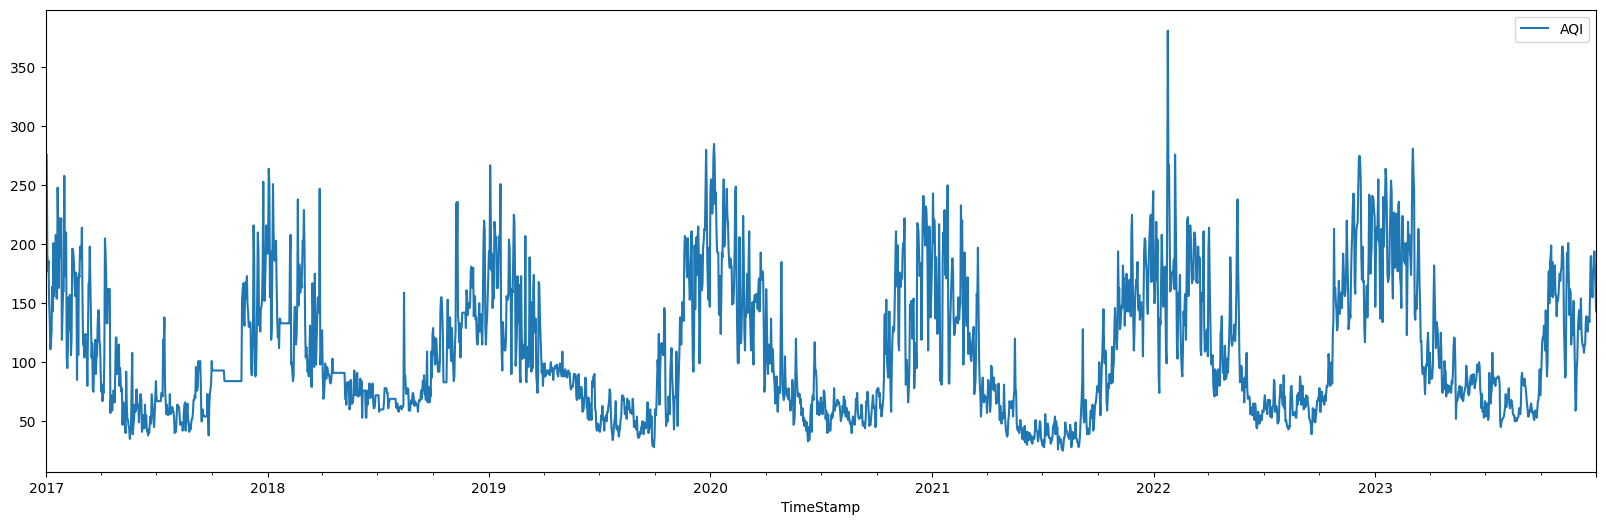

In [49]:
df.plot(figsize=(20, 6))

In [ ]:
df.to_excel('pre_processed_data.xlsx')

print("Data saved successfully")

## Read combined excel file of Air Quality Index (records from 2017-01-01 to 2023-12-31)

In [48]:
path = "/kaggle/input/mumbai-aqi-data/pre_processed_data (2).xlsx"

In [49]:
df = pd.read_excel(path)

In [50]:
df

TimeStamp  AQI
0    2017-01-01  276
1    2017-01-02  276
2    2017-01-03  192
3    2017-01-04  177
4    2017-01-05  186
...         ...  ...
2551 2023-12-27  174
2552 2023-12-28  194
2553 2023-12-29  181
2554 2023-12-30  161
2555 2023-12-31  143

[2556 rows x 2 columns]

In [51]:
df.set_index('TimeStamp', inplace=True)

# Monthly Forecasting

### Converting daily data into monthly data by taking mean. 

In [95]:
monthly_avg = df['AQI'].resample('M').mean()

monthly_df = pd.DataFrame({
    'MAQI': monthly_avg,
})

monthly_df

/tmp/ipykernel_33/1879964061.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['AQI'].resample('M').mean()


MAQI
TimeStamp             
2017-01-31  179.709677
2017-02-28  158.535714
2017-03-31  124.161290
2017-04-30  106.666667
2017-05-31   63.354839
...                ...
2023-08-31   62.322581
2023-09-30   66.166667
2023-10-31  145.548387
2023-11-30  141.500000
2023-12-31  143.935484

[84 rows x 1 columns]

In [97]:
monthly_df.index = pd.to_datetime(monthly_df.index)

### Time Series Plot

<Axes: xlabel='TimeStamp'>

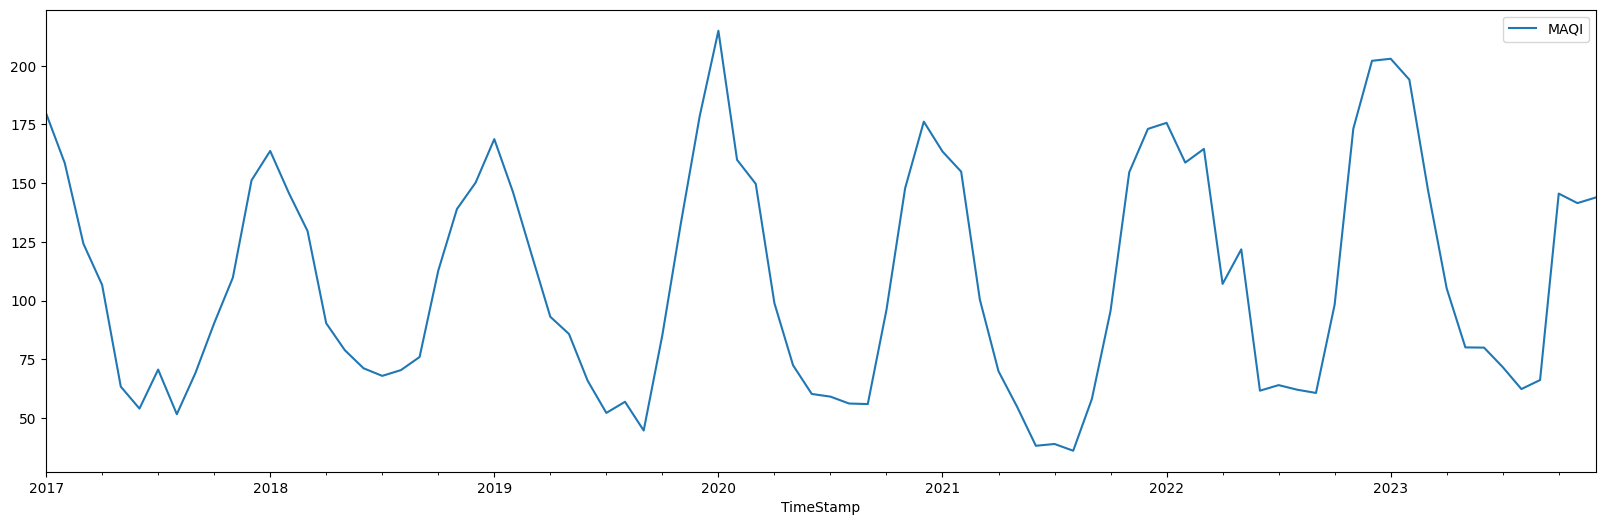

In [98]:
monthly_df.plot(figsize=(20, 6))

### Time Series Mean and Standard Deviation Plot to check whether data is stationary or not

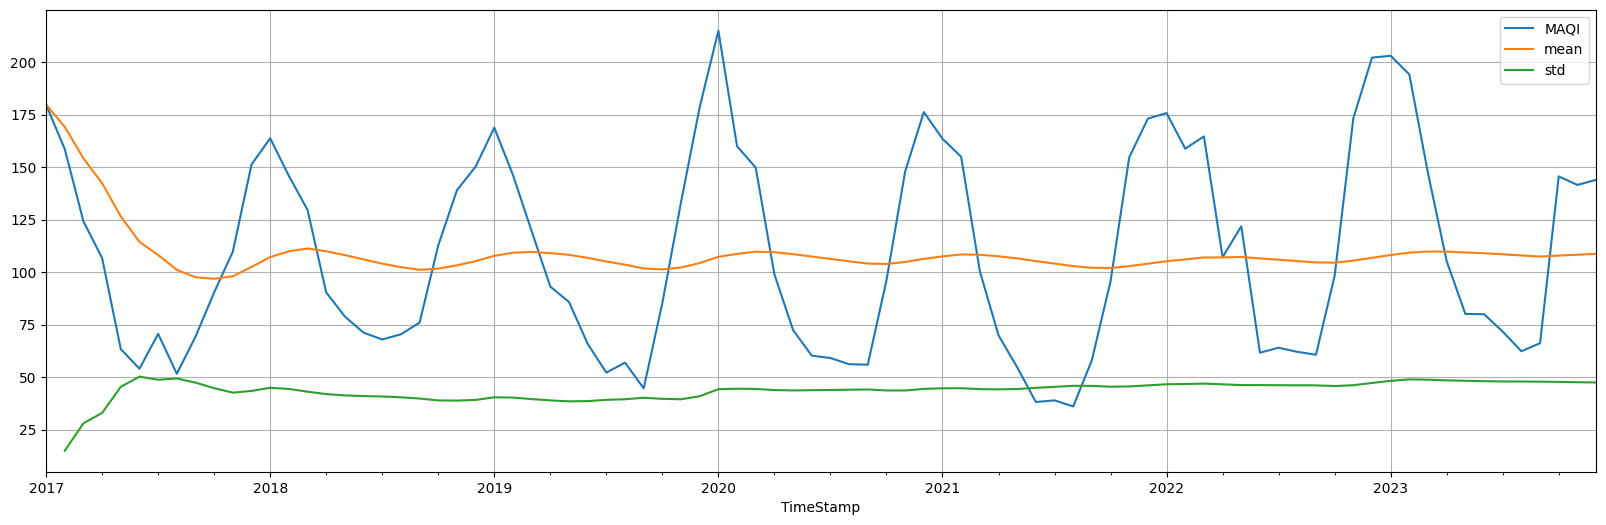

In [99]:
monthly_df.plot(figsize=(20, 6), label='Monthly Mean AQI')
monthly_df['MAQI'].expanding().mean().plot(figsize=(20, 6), label='mean')
monthly_df['MAQI'].expanding().std().plot(figsize=(20, 6), label='std')
plt.legend()
plt.grid(True)

## Augmented Dickey Fuller Test

H0 = Time Series is not Stationary

H1 = Time Series is Stationary

if p <= 0.05: Accept H0

else: Reject H0

In [56]:
def dickey_fuller_test(series):
  adftest = adfuller(series)
  print("ADF-Statistic:", adftest[0])
  print("P-Value:", adftest[1])
  print("Number of lags:", adftest[2])
  print("Number of observations:", adftest[3])
  print("Critical Values", adftest[4])

  if adftest[1] <= 0.05:
    print("Reject Null Hypothesis. Series is Stationary")
  else:
    print("Accept Null Hypothesis. Series is not stationary")

In [57]:
dickey_fuller_test(monthly_df['MAQI'])

ADF-Statistic: -1.9393386339210612
P-Value: 0.3137871664173123
Number of lags: 12
Number of observations: 71
Critical Values {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}
Accept Null Hypothesis. Series is not stationary


## Differencing 

### 1st Order

In [58]:
monthly_df['1st Diff'] = monthly_df['MAQI'] - monthly_df['MAQI'].shift(1)

In [59]:
monthly_df.drop(monthly_df.index[0], inplace=True)

monthly_df

MAQI   1st Diff
TimeStamp                        
2017-02-28  158.535714 -21.173963
2017-03-31  124.161290 -34.374424
2017-04-30  106.666667 -17.494624
2017-05-31   63.354839 -43.311828
2017-06-30   54.000000  -9.354839
...                ...        ...
2023-08-31   62.322581  -9.354839
2023-09-30   66.166667   3.844086
2023-10-31  145.548387  79.381720
2023-11-30  141.500000  -4.048387
2023-12-31  143.935484   2.435484

[83 rows x 2 columns]

In [60]:
dickey_fuller_test(monthly_df['1st Diff'])

ADF-Statistic: -8.062315225101402
P-Value: 1.630531986587894e-12
Number of lags: 9
Number of observations: 73
Critical Values {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}
Reject Null Hypothesis. Series is Stationary


### On 1st order differencing, time series is stationary 👆

### Time Series Mean and Standard Deviation of '1st order diff' plot to check whether data is stationary or not

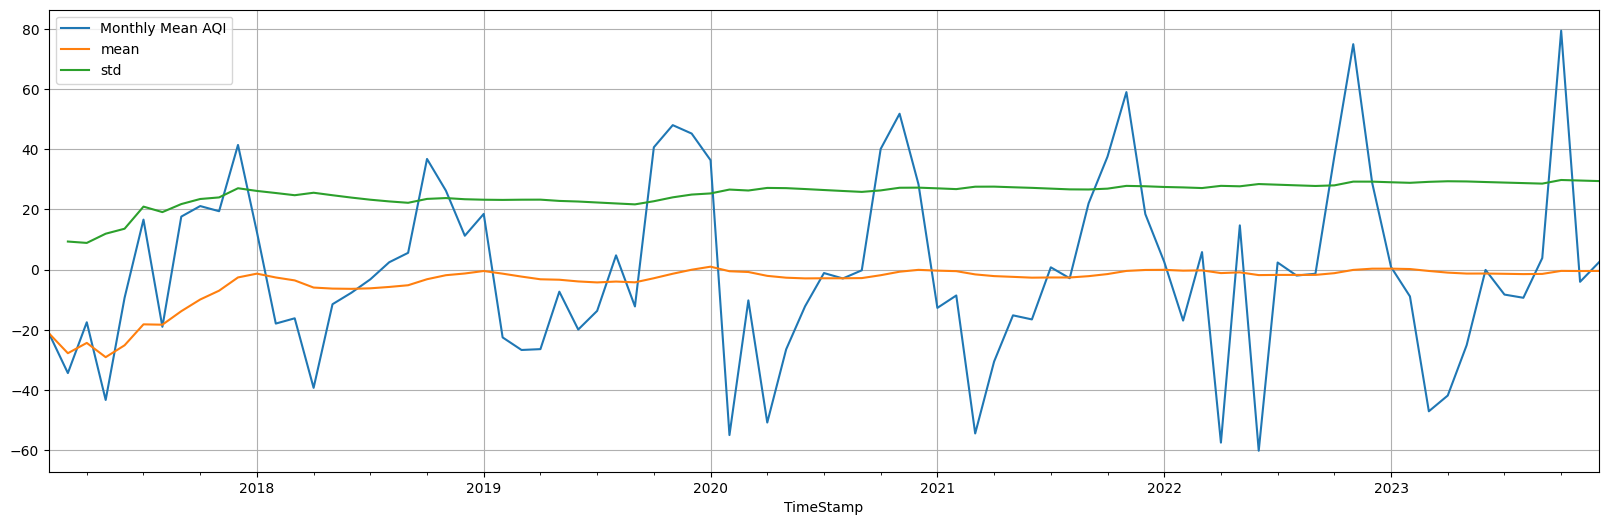

In [61]:
monthly_df['1st Diff'].plot(figsize=(20, 6), label='Monthly Mean AQI')
monthly_df['1st Diff'].expanding().mean().plot(figsize=(20, 6), label='mean')
monthly_df['1st Diff'].expanding().std().plot(figsize=(20, 6), label='std')
plt.legend()
plt.grid(True)

## Auto Correlation plot

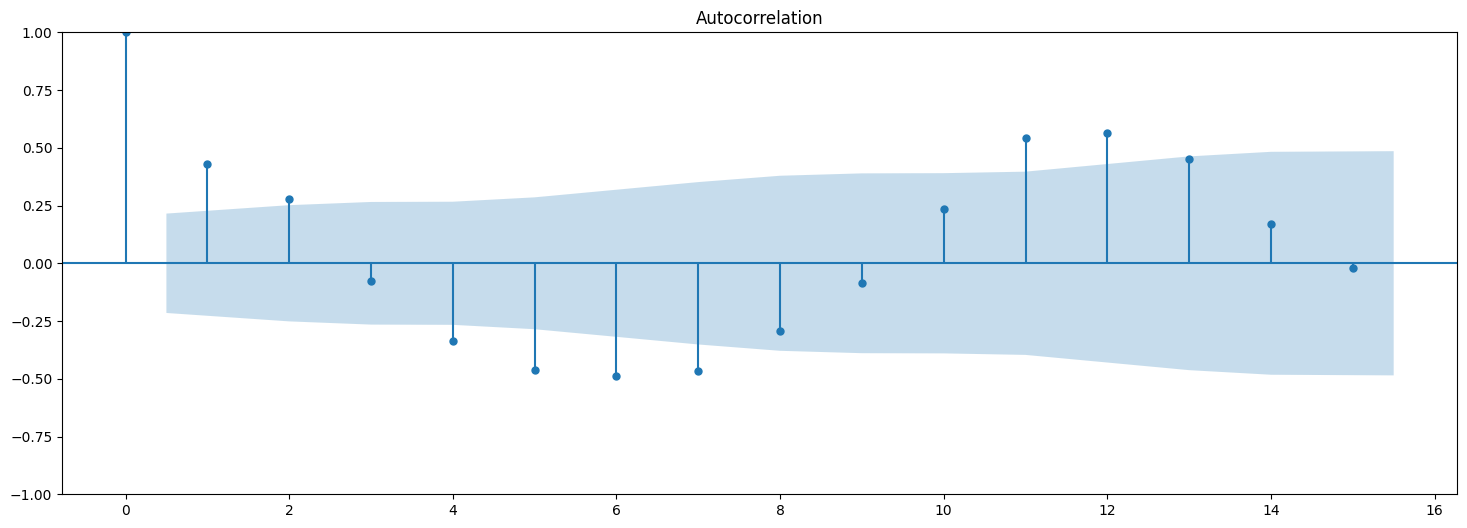

In [62]:
fig, ax = plt.subplots(figsize=(18, 6))
acf_plot = plot_acf(monthly_df['1st Diff'], lags=15, ax=ax)

## Partial Auto Correlation plot

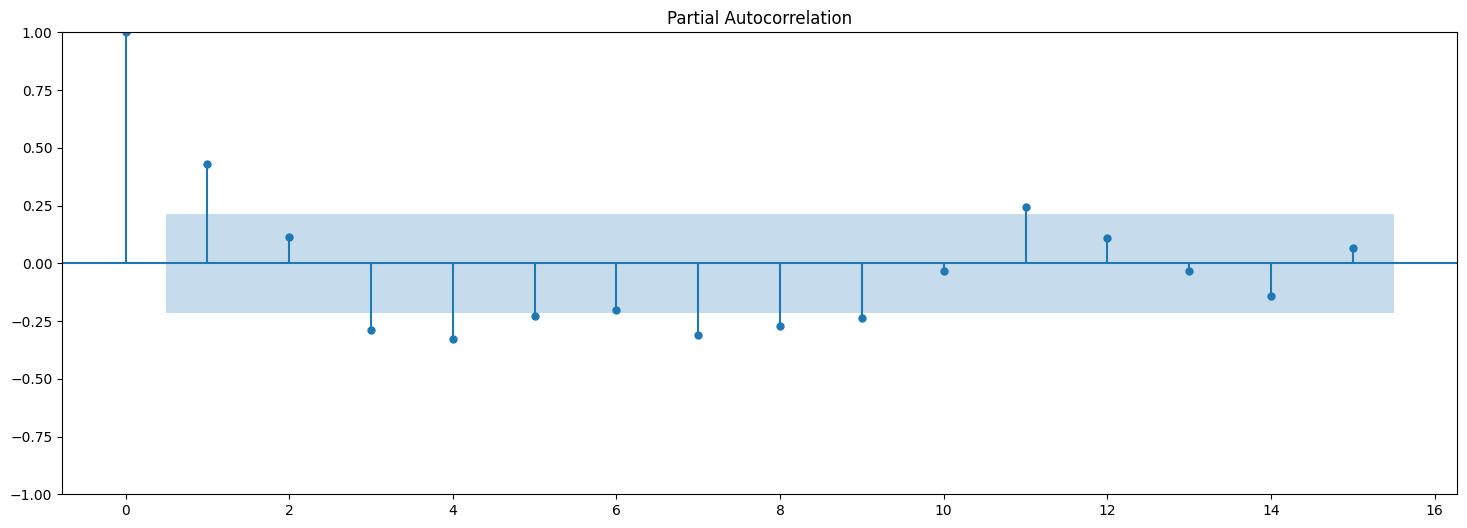

In [63]:
fig, ax = plt.subplots(figsize=(18, 6))
acf_plot = plot_pacf(monthly_df['1st Diff'], lags=15, ax=ax)

In [64]:
train_start_date, train_end_date, test_start_date = '2017-01-01', '2021-12-31', '2022-01-01'

In [65]:
param = 'MAQI'

In [66]:
def train_test_arima_model(df, train_start_date, train_end_date, test_start_date, p, i, q):
  train_data = df[(df.index >= train_start_date) & (df.index <= train_end_date)]
  test_data = df[df.index >= test_start_date]
    
  endog = train_data[param]
  model = ARIMA(endog, order=(p, i, q)).fit()

  
  pred = model.predict(start=test_data.index[0], end=test_data.index[-1])
  pred.index = test_data.index
  residuals = test_data[param] - pred
  residuals = pd.DataFrame({'Residuals': residuals}, index=test_data.index)
  return model.summary(), residuals, pred

In [67]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [68]:
def model_evaluation(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    
    return [mae, mse, mape, rmse]

## Auto Regressive Model with order p = 2

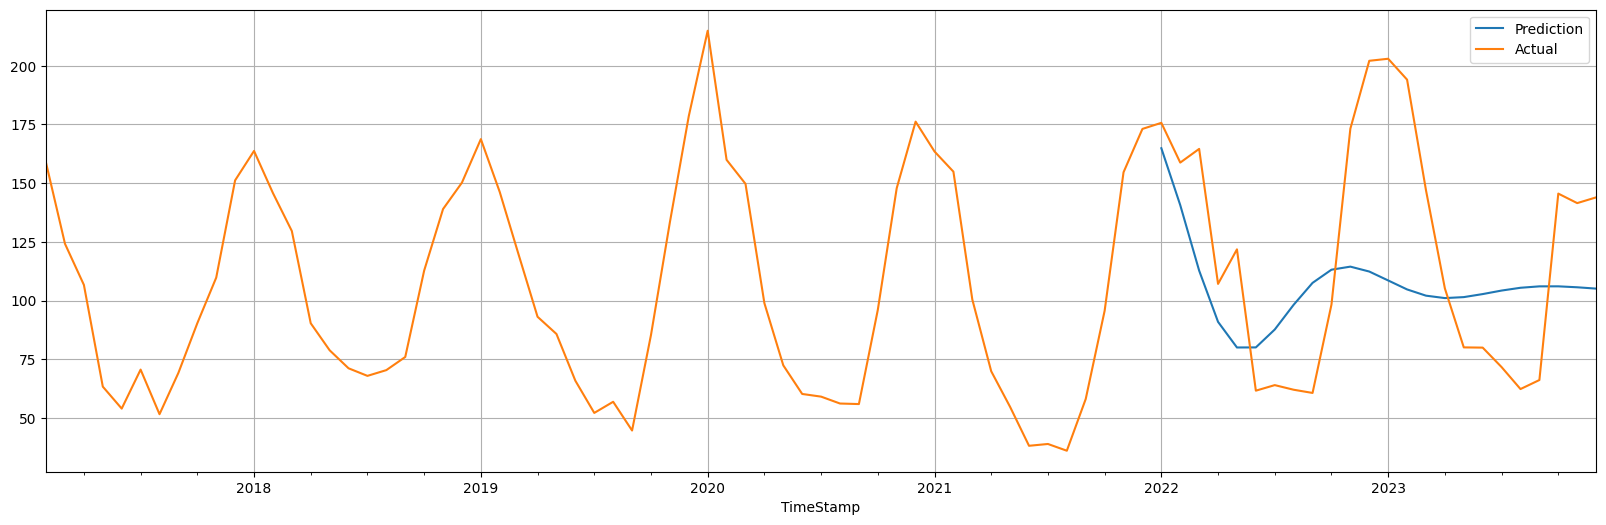

                               SARIMAX Results                                
Dep. Variable:                   MAQI   No. Observations:                   59
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -258.870
Date:                Fri, 26 Apr 2024   AIC                            525.740
Time:                        08:46:28   BIC                            534.050
Sample:                    02-28-2017   HQIC                           528.984
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.7295      8.295     12.625      0.000      88.471     120.988
ar.L1          1.3865      0.102     13.650      0.000       1.187       1.586
ar.L2         -0.6943      0.095     -7.333      0.0

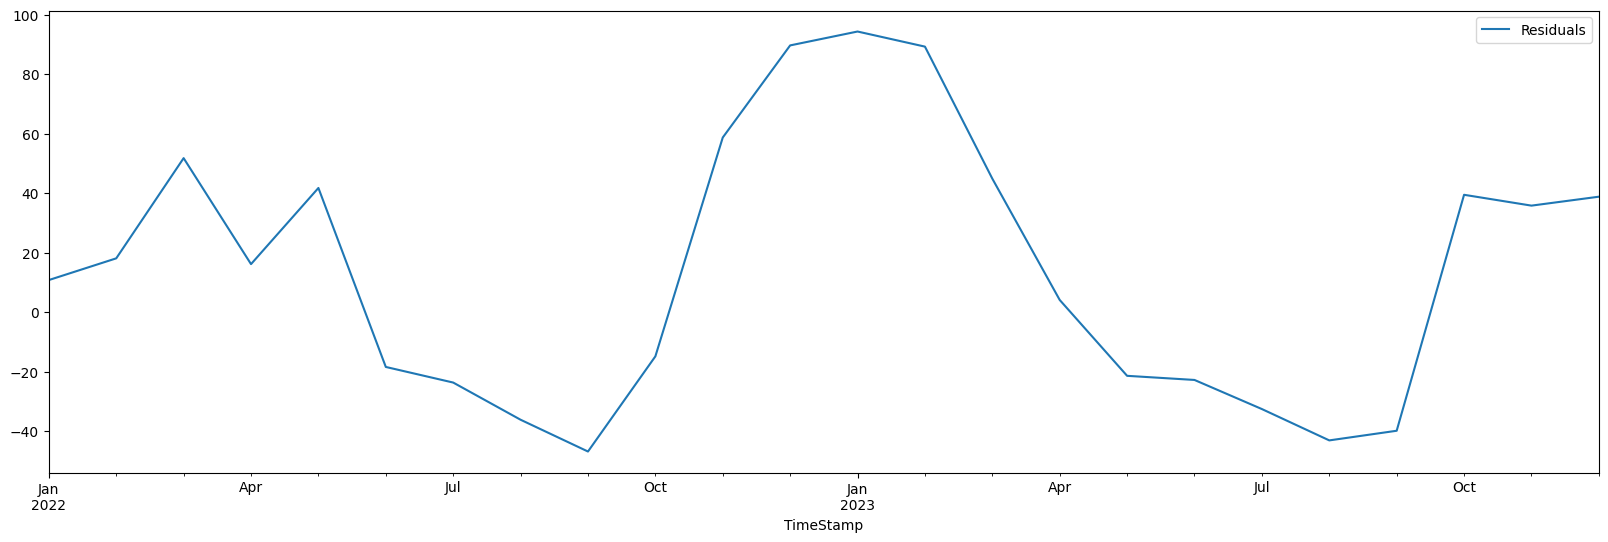

In [69]:
model_summary, residuals, prediction = train_test_arima_model(monthly_df, train_start_date, train_end_date, test_start_date, 2, 0, 0)

prediction.plot(figsize=(20, 6), label='Prediction')
monthly_df['MAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

### From above model summary,
### Expression for Auto Regressive model:
### yt = 104.73 + 1.386 * yt – 1 - 0.694 * yt – 2 + εt



In [31]:
metrics = model_evaluation(monthly_df[monthly_df.index >= test_start_date]['MAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

AR_model_perf = metrics

Mean Absolute Error: 38.911940010712875
Mean Squared Error: 2084.786076522328
Mean Absolute Percentage Error: 34.623606255180746
Root Mean Squared Error: 45.65945768975282


## Moving Average Model with order q = 2

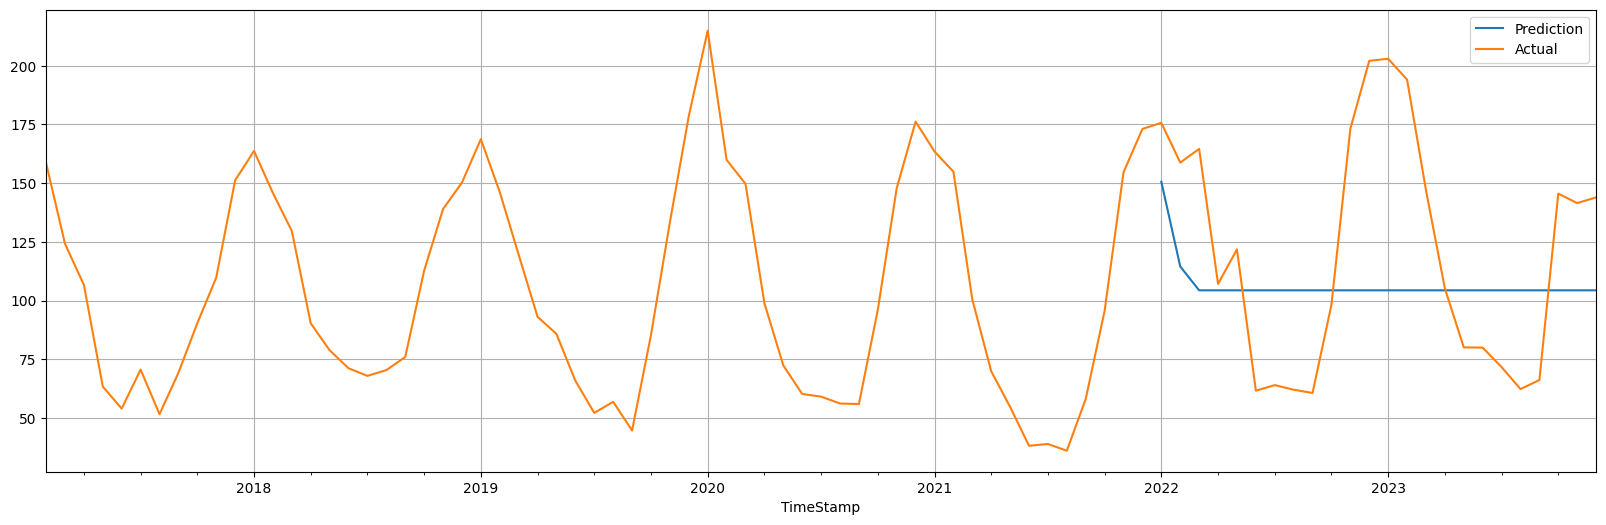

                               SARIMAX Results                                
Dep. Variable:                   MAQI   No. Observations:                   59
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -271.550
Date:                Fri, 26 Apr 2024   AIC                            551.100
Time:                        07:59:12   BIC                            559.410
Sample:                    02-28-2017   HQIC                           554.344
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.3628      8.550     12.207      0.000      87.606     121.120
ma.L1          0.9253      0.101      9.197      0.000       0.728       1.123
ma.L2          0.7630      0.119      6.432      0.0

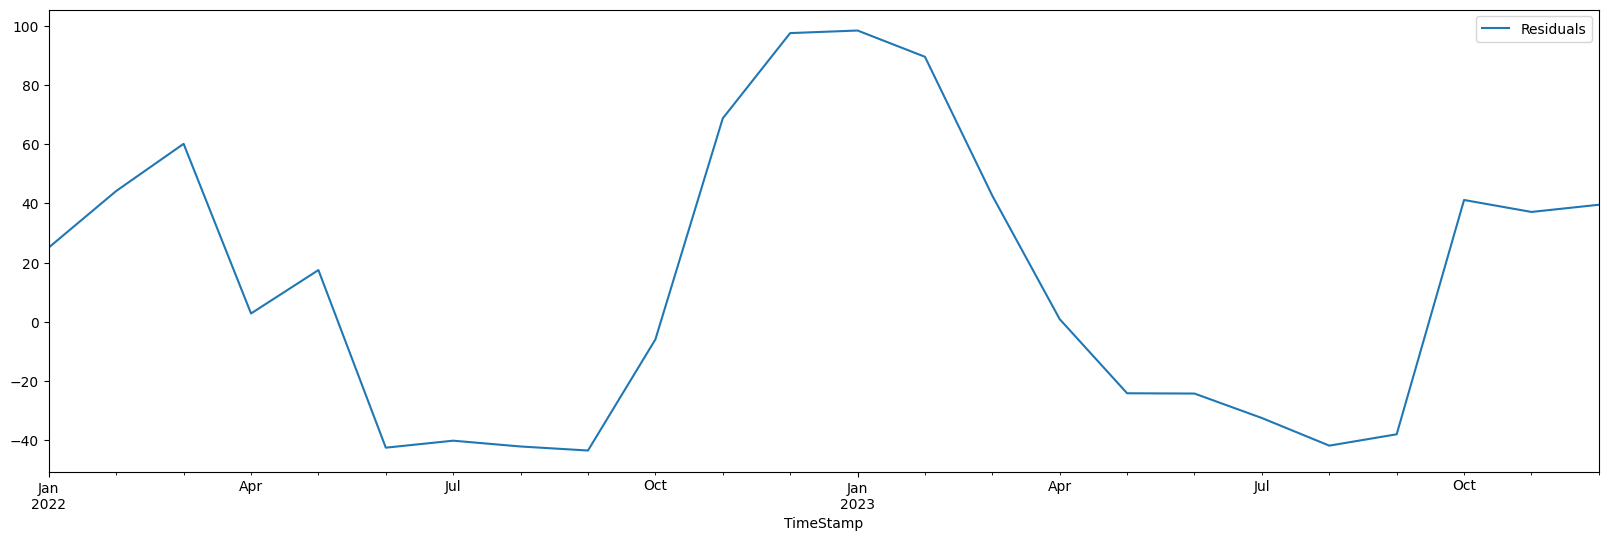

In [32]:
model_summary, residuals, prediction = train_test_arima_model(monthly_df, train_start_date, train_end_date, test_start_date, 0, 0, 2)

prediction.plot(figsize=(20, 6), label='Prediction')
monthly_df['MAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

### From above model summary,
### Expression for Moving Average model:
### yt = 104.36 + 0.9253 * εt – 1 - 0.7630 * εt - 2



In [33]:
metrics = model_evaluation(monthly_df[monthly_df.index >= test_start_date]['MAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

MA_model_perf = metrics

Mean Absolute Error: 41.782402140826804
Mean Squared Error: 2405.009674376803
Mean Absolute Percentage Error: 37.53423754250096
Root Mean Squared Error: 49.04089797686012


## Arima Model with order p = 2, d = 1, q = 2

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


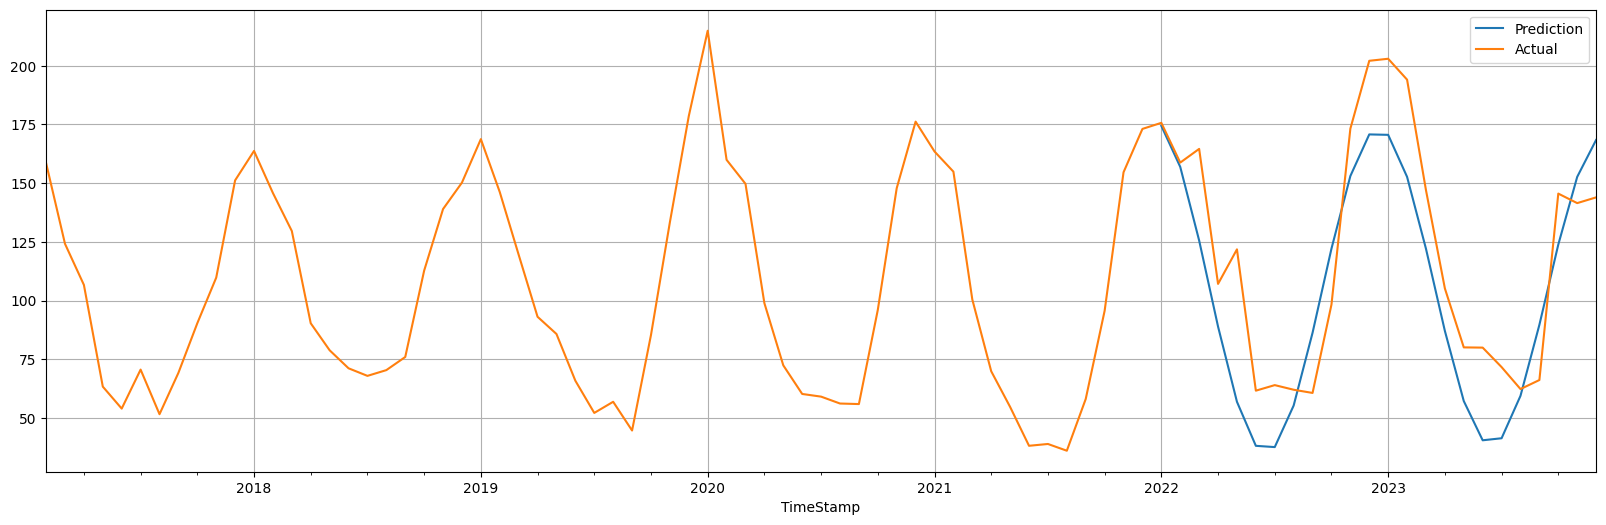

                               SARIMAX Results                                
Dep. Variable:                   MAQI   No. Observations:                   59
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -244.490
Date:                Fri, 26 Apr 2024   AIC                            498.979
Time:                        07:59:23   BIC                            509.281
Sample:                    02-28-2017   HQIC                           502.992
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7220      0.017     99.224      0.000       1.688       1.756
ar.L2         -0.9922      0.014    -69.883      0.000      -1.020      -0.964
ma.L1         -1.8216     10.132     -0.180      0.8

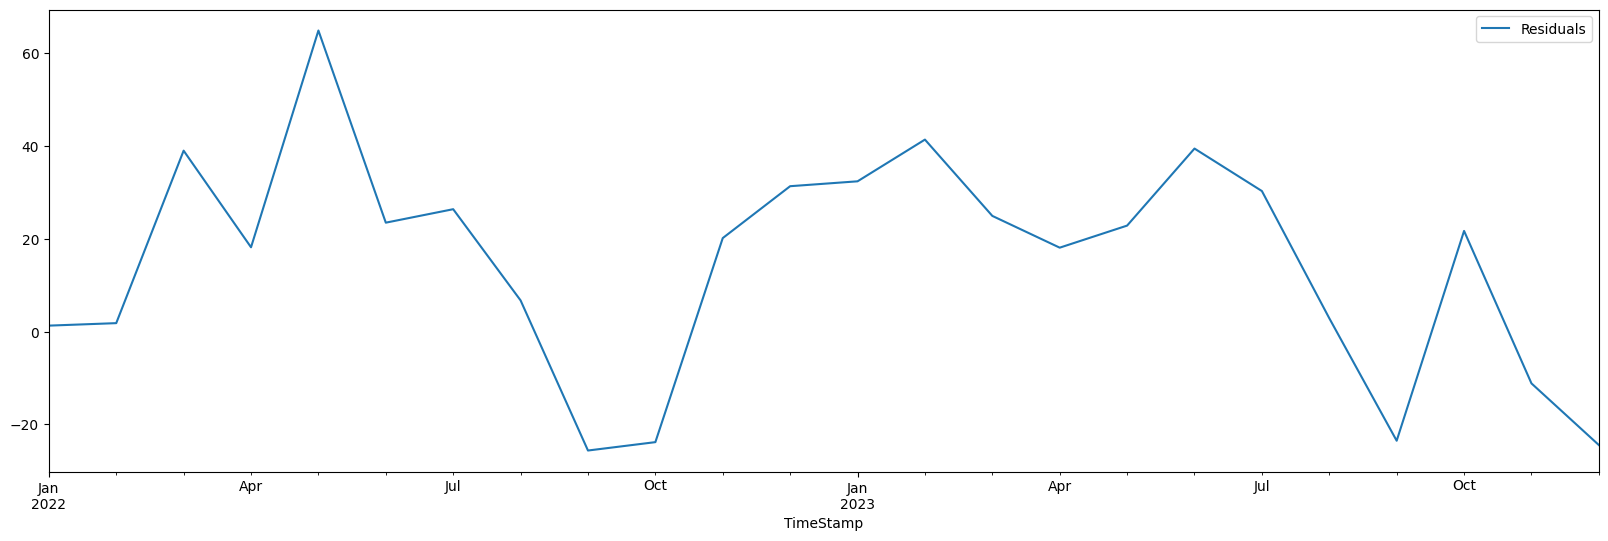

In [34]:
model_summary, residuals, prediction = train_test_arima_model(monthly_df, train_start_date, train_end_date, test_start_date, 2, 1, 2)

prediction.plot(figsize=(20, 6), label='Prediction')
monthly_df['MAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

### From above model summary,
### Expression for Auto Regressive Integrated Moving Average (ARIMA) model:
### yt = 1.722 * yt – 1 - 0.922 * yt – 2 + εt - 1.8216 * εt - 0.9993 * εt - 2  



In [35]:
metrics = model_evaluation(monthly_df[monthly_df.index >= test_start_date]['MAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

ARIMA_model_perf_1 = metrics

Mean Absolute Error: 23.996746909486692
Mean Squared Error: 768.3363250129714
Mean Absolute Percentage Error: 22.968413941145247
Root Mean Squared Error: 27.718880298687598


## Arima Model with order p = 2, d = 1, q = 6

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


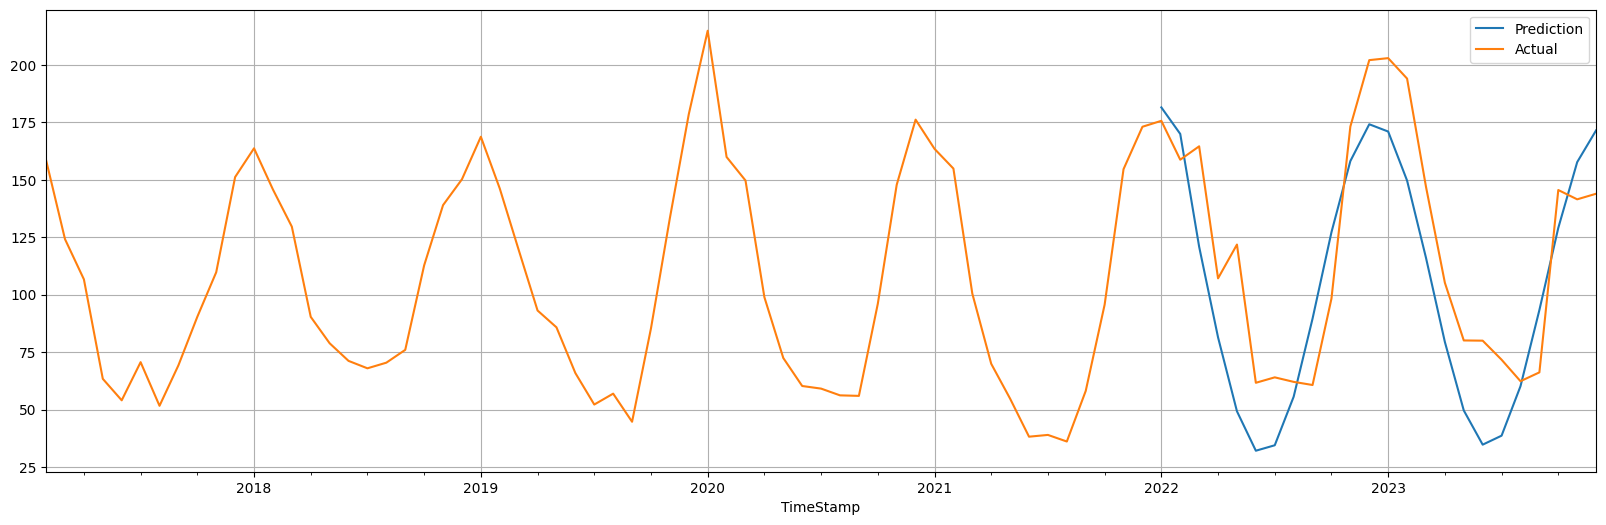

                               SARIMAX Results                                
Dep. Variable:                   MAQI   No. Observations:                   59
Model:                 ARIMA(2, 1, 6)   Log Likelihood                -237.076
Date:                Fri, 26 Apr 2024   AIC                            492.151
Time:                        08:00:04   BIC                            510.695
Sample:                    02-28-2017   HQIC                           499.375
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7216      0.019     91.417      0.000       1.685       1.759
ar.L2         -0.9924      0.017    -57.083      0.000      -1.026      -0.958
ma.L1         -2.1635      7.389     -0.293      0.7

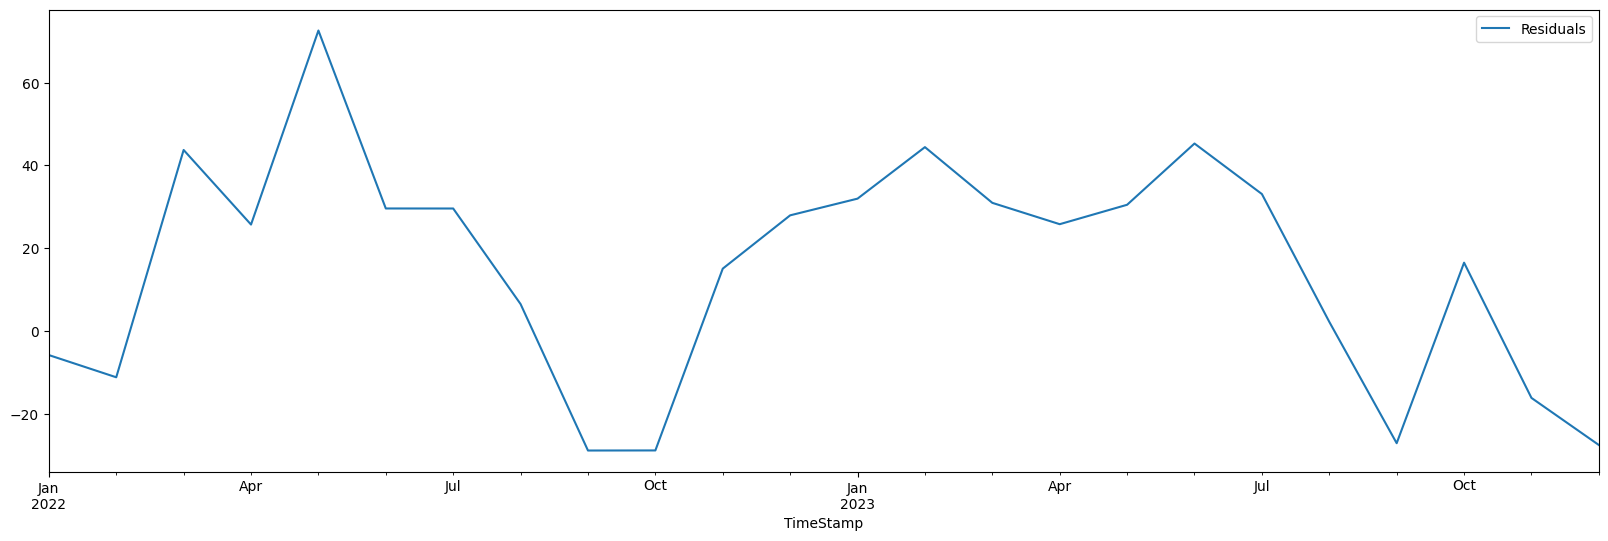

In [36]:
model_summary, residuals, prediction = train_test_arima_model(monthly_df, train_start_date, train_end_date, test_start_date, 2, 1, 6)

prediction.plot(figsize=(20, 6), label='Prediction')
monthly_df['MAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

In [37]:
metrics = model_evaluation(monthly_df[monthly_df.index >= test_start_date]['MAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

ARIMA_model_perf_2 = metrics

Mean Absolute Error: 27.370472618066575
Mean Squared Error: 966.1431750628549
Mean Absolute Percentage Error: 26.50604547551385
Root Mean Squared Error: 31.08284374156996


In [38]:
def train_test_SARIMAX_model(df, train_start_date, train_end_date, test_start_date, p, i, q, P, I, Q, S):
  train_data = df[(df.index >= train_start_date) & (df.index <= train_end_date)]
  test_data = df[df.index >= test_start_date]
  endog = train_data[param]
  model = SARIMAX(endog, order=(p, i, q), seasonal_order=(P, I, Q, S)).fit()
  # _________________________________________________________________________________
  pred = model.predict(start=test_data.index[0], end=test_data.index[-1])
  pred.index = test_data.index
  residuals = test_data[param] - pred
  residuals = pd.DataFrame({'Residuals': residuals}, index=test_data.index)
  return model.summary(), residuals, pred

## Sarima Model with order p = 0, d = 1, q = 0, P = 4, D = 1, Q = 6, S = 12

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42872D+00    |proj g|=  2.66278D-01


 This problem is unconstrained.



At iterate    5    f=  3.34154D+00    |proj g|=  9.11835D-03

At iterate   10    f=  3.32898D+00    |proj g|=  1.89228D-02

At iterate   15    f=  3.32669D+00    |proj g|=  2.28868D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     16     18      1     0     0   7.947D-06   3.327D+00
  F =   3.3266947241975018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


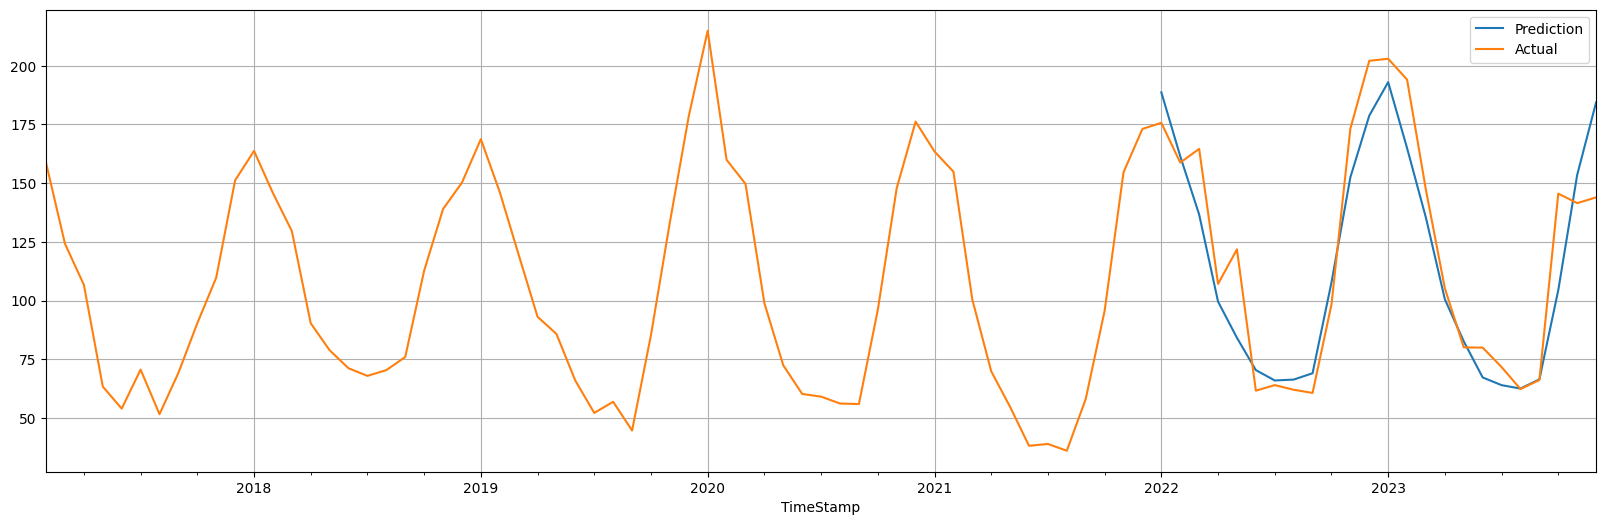

                                              SARIMAX Results                                              
Dep. Variable:                                                MAQI   No. Observations:                   59
Model:             SARIMAX(0, 1, 0)x(4, 1, [1, 2, 3, 4, 5, 6], 12)   Log Likelihood                -196.275
Date:                                             Fri, 26 Apr 2024   AIC                            414.550
Time:                                                     08:00:42   BIC                            434.665
Sample:                                                 02-28-2017   HQIC                           422.085
                                                      - 12-31-2021                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

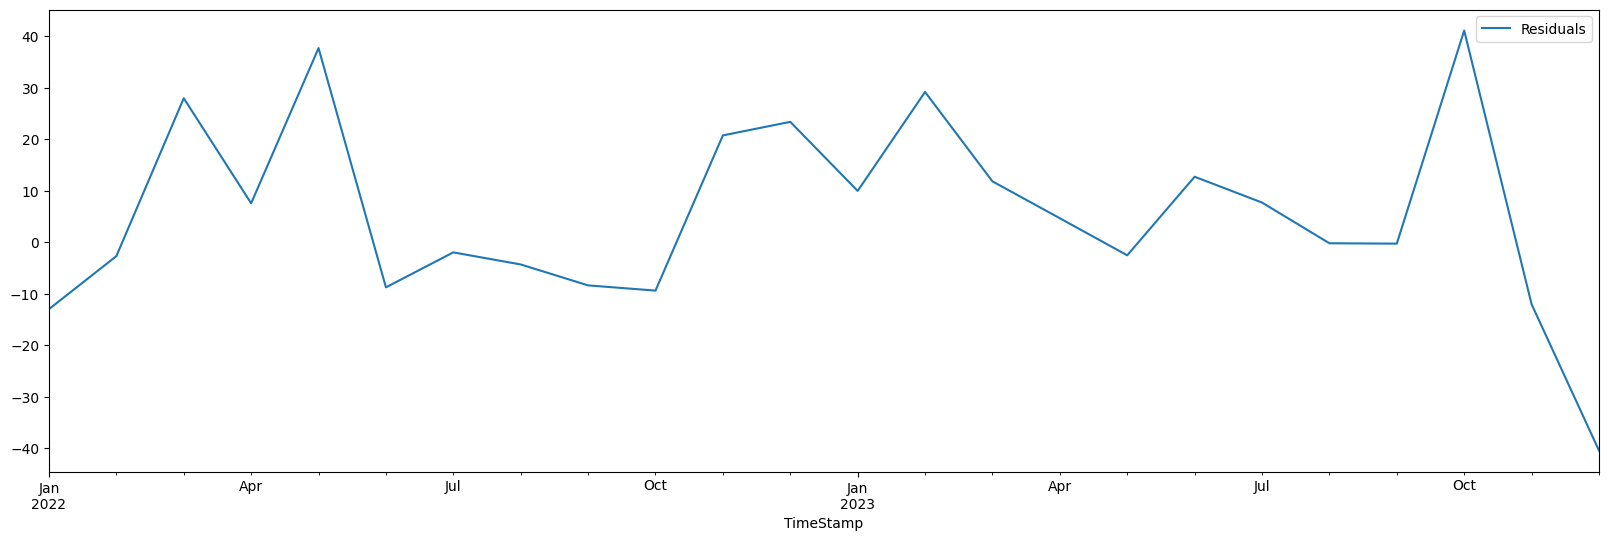

In [39]:
model_summary, residuals, prediction = train_test_SARIMAX_model(monthly_df, train_start_date, train_end_date, test_start_date, 0, 1, 0, 4, 1, 6, 12)

prediction.plot(figsize=(20, 6), label='Prediction')
monthly_df['MAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

Seasonal component: (4, 1, [1, 2, 3, 4, 5, 6], 12)

Seasonal AR terms (P): (4) indicates there are 4 seasonal autoregressive terms (SAR) used to model the relationship between the current observation and its seasonal lags (lag 12, lag 24, lag 36, and lag 48 in this case).

Seasonal differencing (D): (1) suggests that first-order seasonal differencing is applied to the data (D=1), meaning that each observation is differenced with its value from the same month in the previous year.

Seasonal MA terms (Q): ([1, 2, 3, 4, 5, 6]) indicates there are multiple seasonal moving average terms (SMA) included in the model. In this example, there are 6 SMA terms corresponding to the first 6 seasonal lags.

Seasonal Period (S): (12) specifies that the seasonal pattern repeats every 12 months, indicating monthly seasonality.

In [40]:
metrics = model_evaluation(monthly_df[monthly_df.index >= test_start_date]['MAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

SARIMA_model_perf = metrics

Mean Absolute Error: 14.095264423297955
Mean Squared Error: 352.8625474315995
Mean Absolute Percentage Error: 10.956610040868105
Root Mean Squared Error: 18.784635940885295


# Weekly Forecast

In [70]:
weekly_avg = df['AQI'].resample('W').mean()

weekly_df = pd.DataFrame({
    'WAQI': weekly_avg,
})

weekly_df

WAQI
TimeStamp             
2017-01-01  276.000000
2017-01-08  175.571429
2017-01-15  153.857143
2017-01-22  187.000000
2017-01-29  180.285714
...                ...
2023-12-03  103.571429
2023-12-10  126.857143
2023-12-17  124.142857
2023-12-24  158.571429
2023-12-31  169.428571

[366 rows x 1 columns]

In [71]:
weekly_df.index = pd.to_datetime(weekly_df.index)

<Axes: xlabel='TimeStamp'>

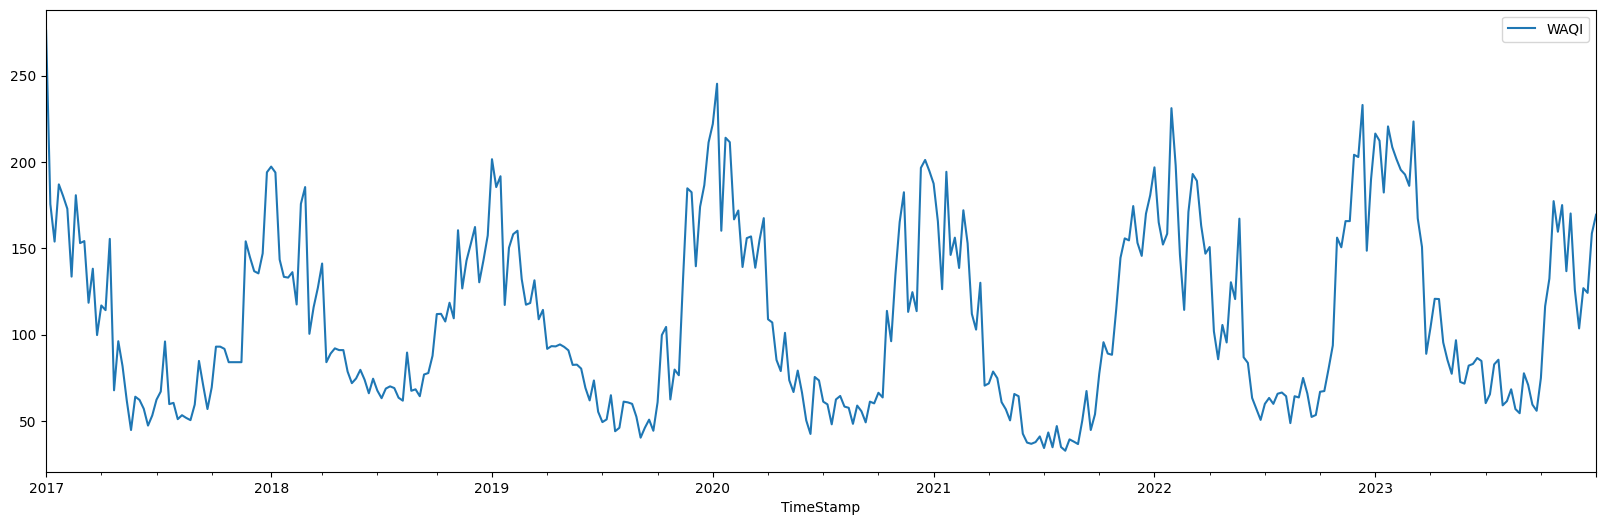

In [72]:
weekly_df.plot(figsize=(20, 6))

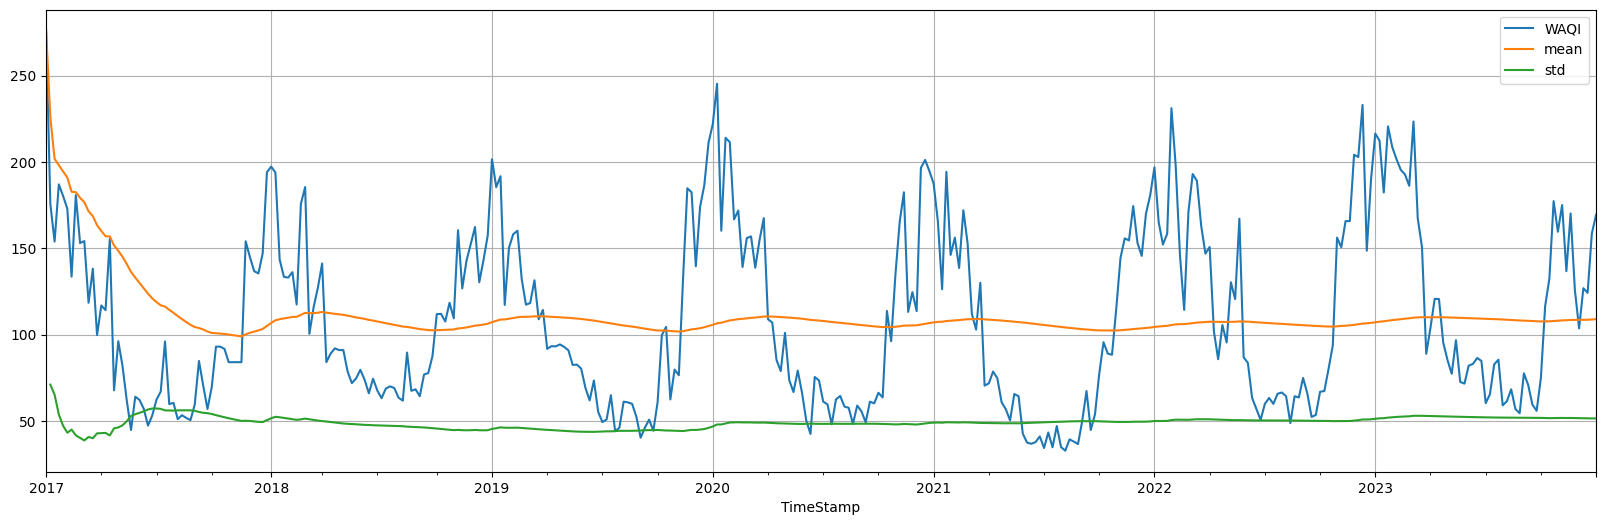

In [73]:
weekly_df.plot(figsize=(20, 6), label='Weekly Mean AQI')
weekly_df['WAQI'].expanding().mean().plot(figsize=(20, 6), label='mean')
weekly_df['WAQI'].expanding().std().plot(figsize=(20, 6), label='std')
plt.legend()
plt.grid(True)

In [74]:
dickey_fuller_test(weekly_df['WAQI'])

ADF-Statistic: -6.706832327397921
P-Value: 3.76655391935385e-09
Number of lags: 14
Number of observations: 351
Critical Values {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}
Reject Null Hypothesis. Series is Stationary


<Axes: xlabel='TimeStamp'>

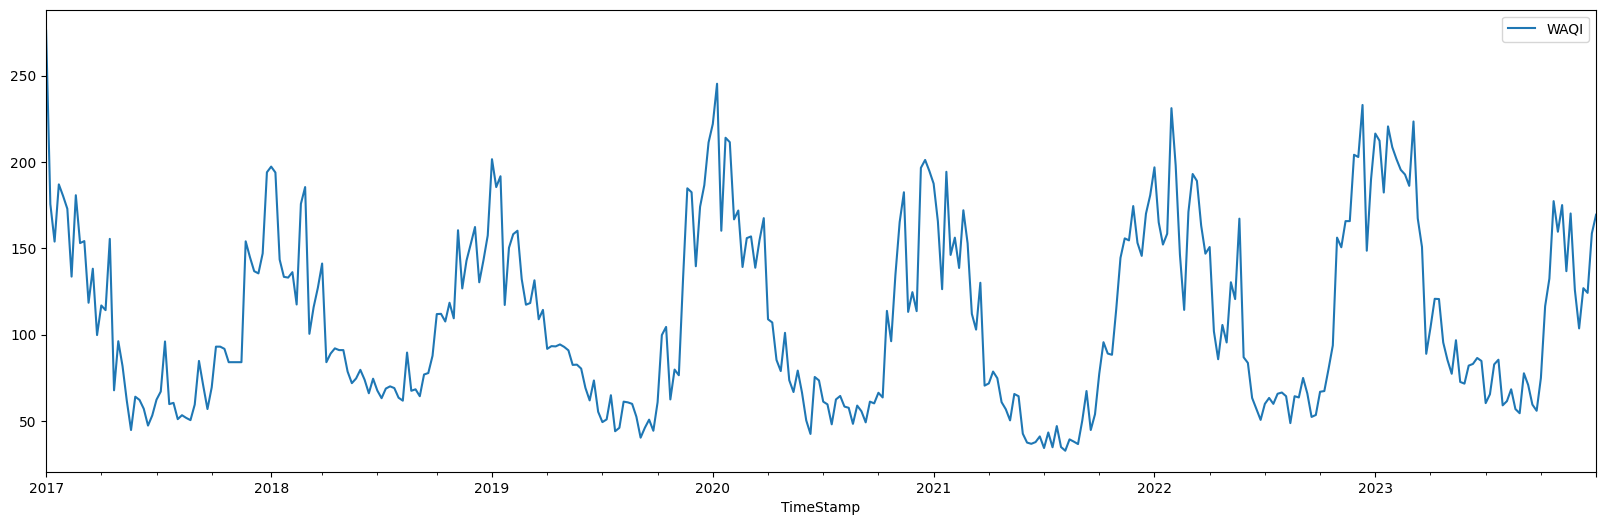

In [75]:
weekly_df.plot(figsize=(20, 6))

In [76]:
weekly_df.tail(10)

WAQI
TimeStamp             
2023-10-29  159.571429
2023-11-05  175.000000
2023-11-12  136.714286
2023-11-19  170.142857
2023-11-26  125.857143
2023-12-03  103.571429
2023-12-10  126.857143
2023-12-17  124.142857
2023-12-24  158.571429
2023-12-31  169.428571

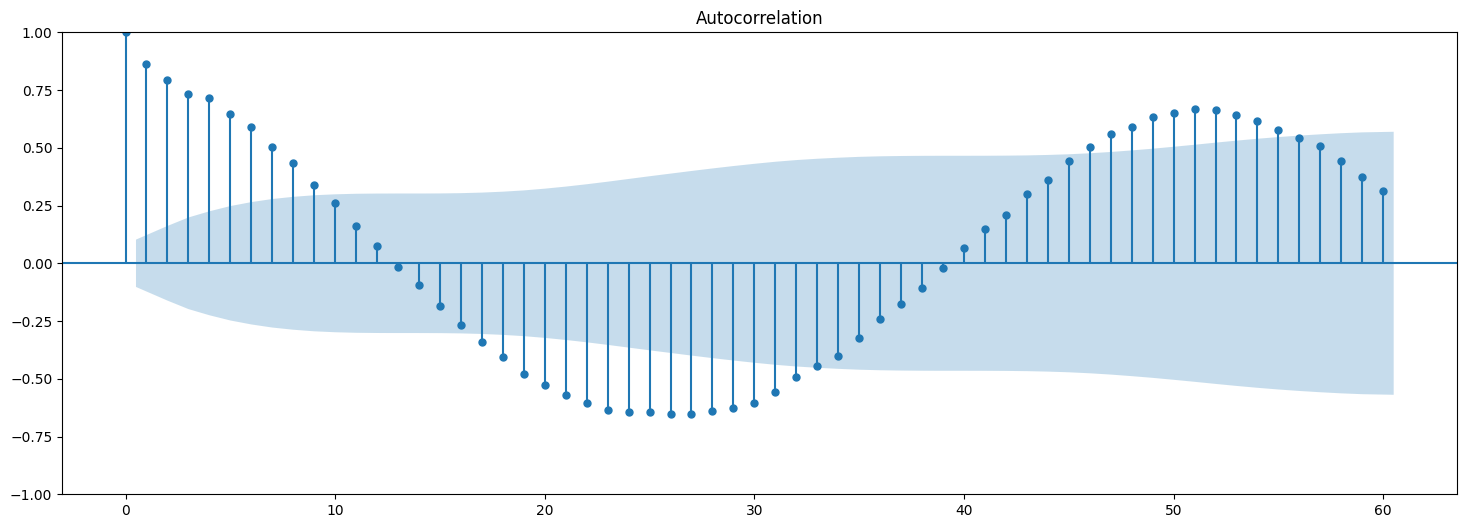

In [77]:
fig, ax = plt.subplots(figsize=(18, 6))
acf_plot = plot_acf(weekly_df['WAQI'], lags=60, ax=ax)

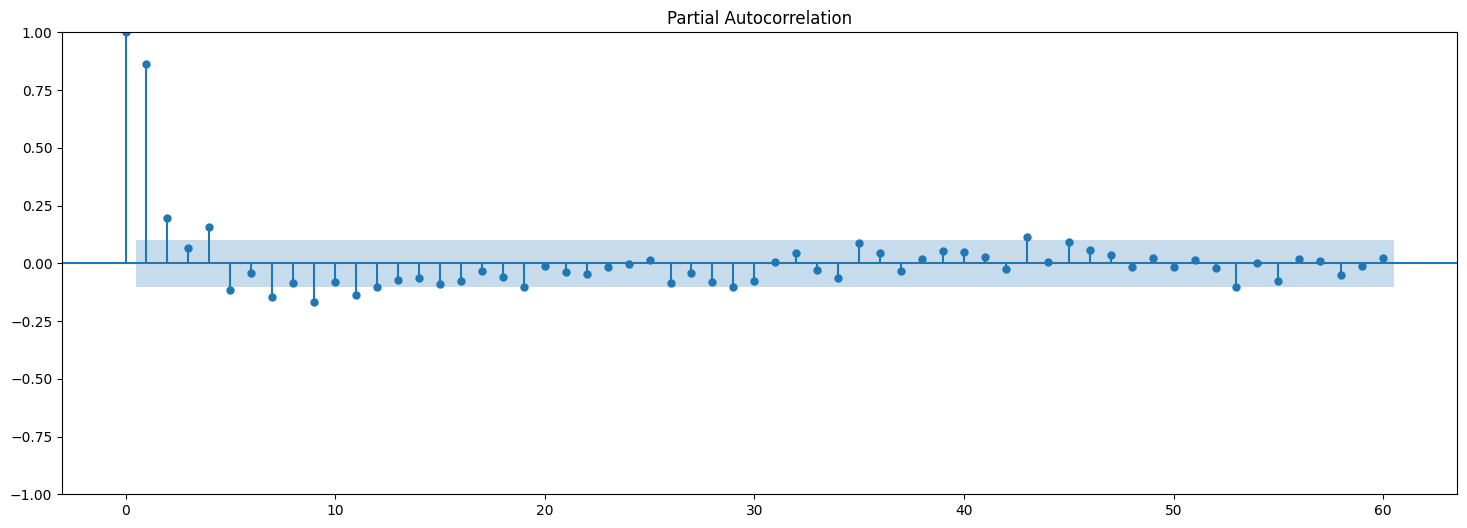

In [78]:
fig, ax = plt.subplots(figsize=(18, 6))
acf_plot = plot_pacf(weekly_df['WAQI'], lags=60, ax=ax)

In [79]:
train_start_date, train_end_date, test_start_date = '2017-01-01', '2021-12-31', '2022-01-01'

In [81]:
param = 'WAQI'

## Auto Regressive Model with p = 9

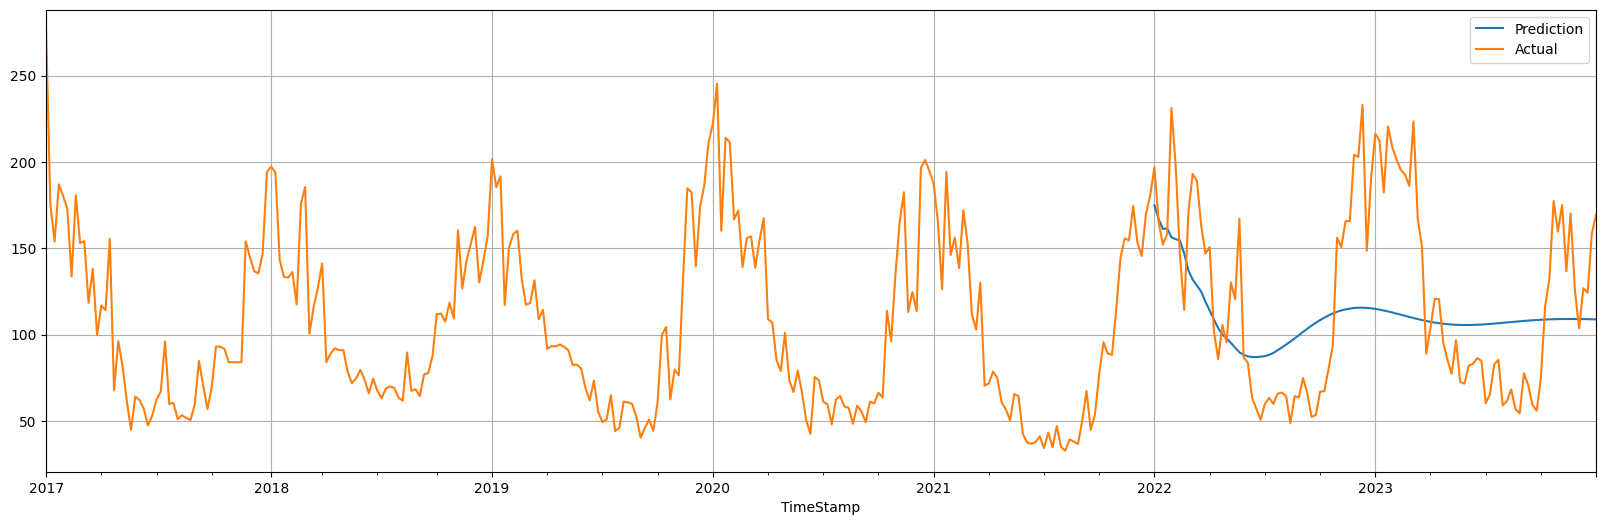

                               SARIMAX Results                                
Dep. Variable:                   WAQI   No. Observations:                  261
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -1173.805
Date:                Fri, 26 Apr 2024   AIC                           2369.610
Time:                        08:48:21   BIC                           2408.820
Sample:                    01-01-2017   HQIC                          2385.371
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.1224     11.589      9.330      0.000      85.409     130.836
ar.L1          0.6332      0.054     11.690      0.000       0.527       0.739
ar.L2          0.0648      0.077      0.846      0.3

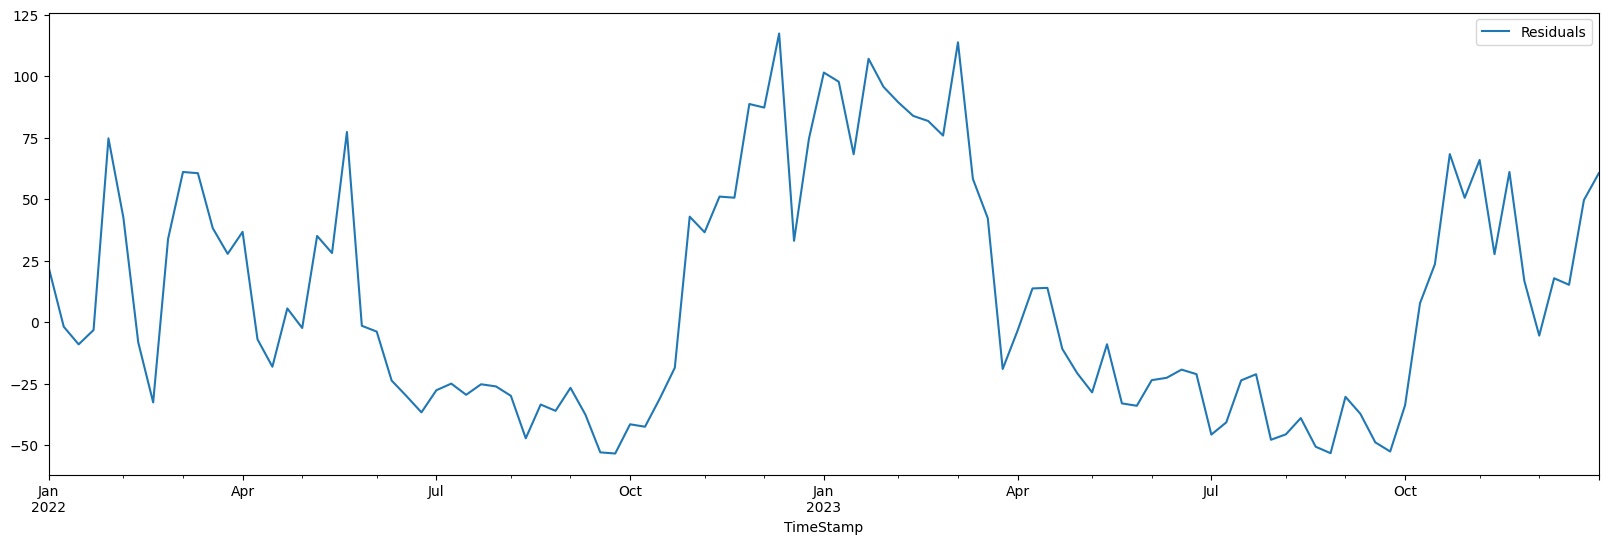

In [84]:
model_summary, residuals, prediction = train_test_arima_model(weekly_df, train_start_date, train_end_date, test_start_date, 9, 0, 0)

prediction.plot(figsize=(20, 6), label='Prediction')
weekly_df['WAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

In [85]:
metrics = model_evaluation(weekly_df[weekly_df.index >= test_start_date]['WAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

AR_weekly = metrics

Mean Absolute Error: 40.177350175605916
Mean Squared Error: 2325.0187167314357
Mean Absolute Percentage Error: 36.69516858926993
Root Mean Squared Error: 48.21844788803799


## Moving Average with q = 8 

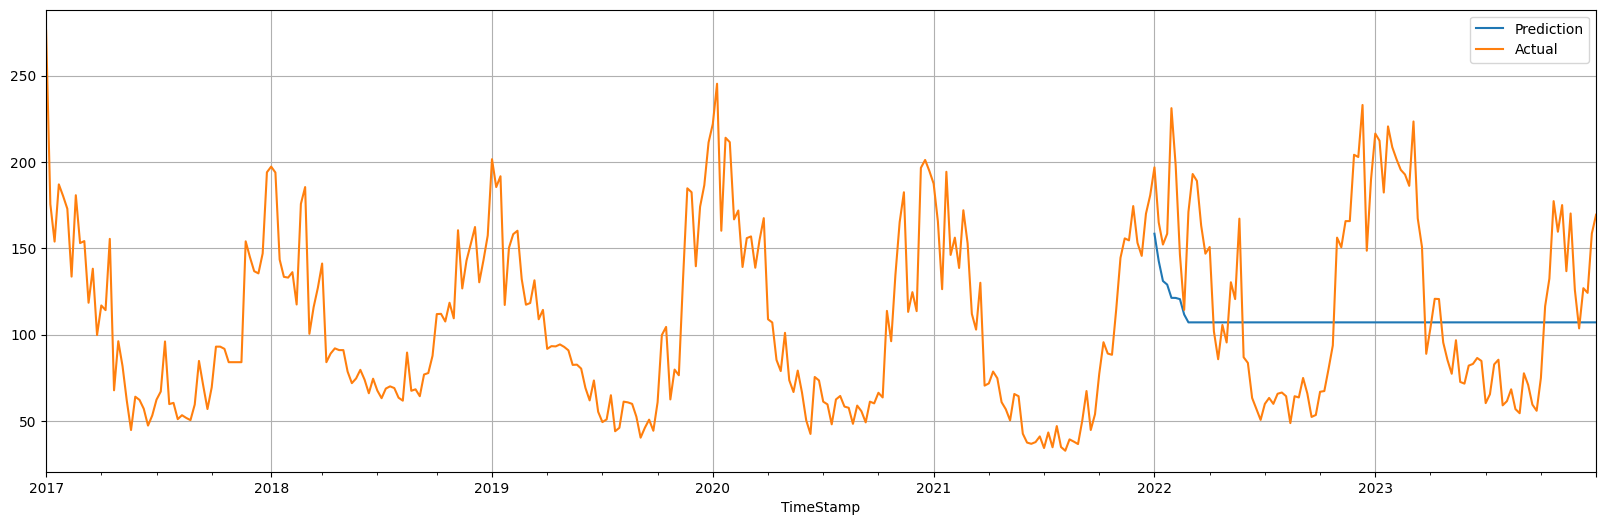

                               SARIMAX Results                                
Dep. Variable:                   WAQI   No. Observations:                  261
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -1195.075
Date:                Fri, 26 Apr 2024   AIC                           2410.149
Time:                        08:49:35   BIC                           2445.794
Sample:                    01-01-2017   HQIC                          2424.478
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.0665      8.383     12.771      0.000      90.635     123.498
ma.L1          0.7257      0.053     13.773      0.000       0.622       0.829
ma.L2          0.5504      0.066      8.306      0.0

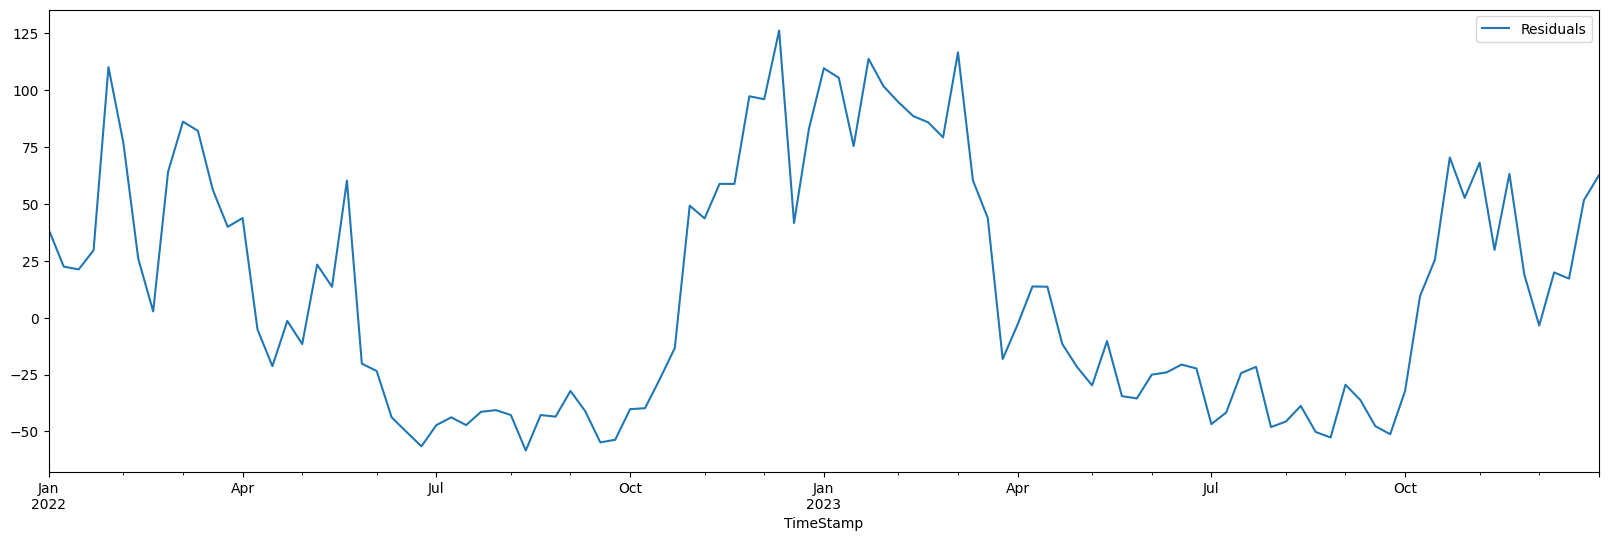

In [87]:
model_summary, residuals, prediction = train_test_arima_model(weekly_df, train_start_date, train_end_date, test_start_date, 0, 0, 8)

prediction.plot(figsize=(20, 6), label='Prediction')
weekly_df['WAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

In [88]:
metrics = model_evaluation(weekly_df[weekly_df.index >= test_start_date]['WAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

MA_weekly = metrics

Mean Absolute Error: 45.76549371425437
Mean Squared Error: 2893.606118916346
Mean Absolute Percentage Error: 41.97673211273328
Root Mean Squared Error: 53.79224961754571


## ARIMA model with p = 9, d = 0, q = 8

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


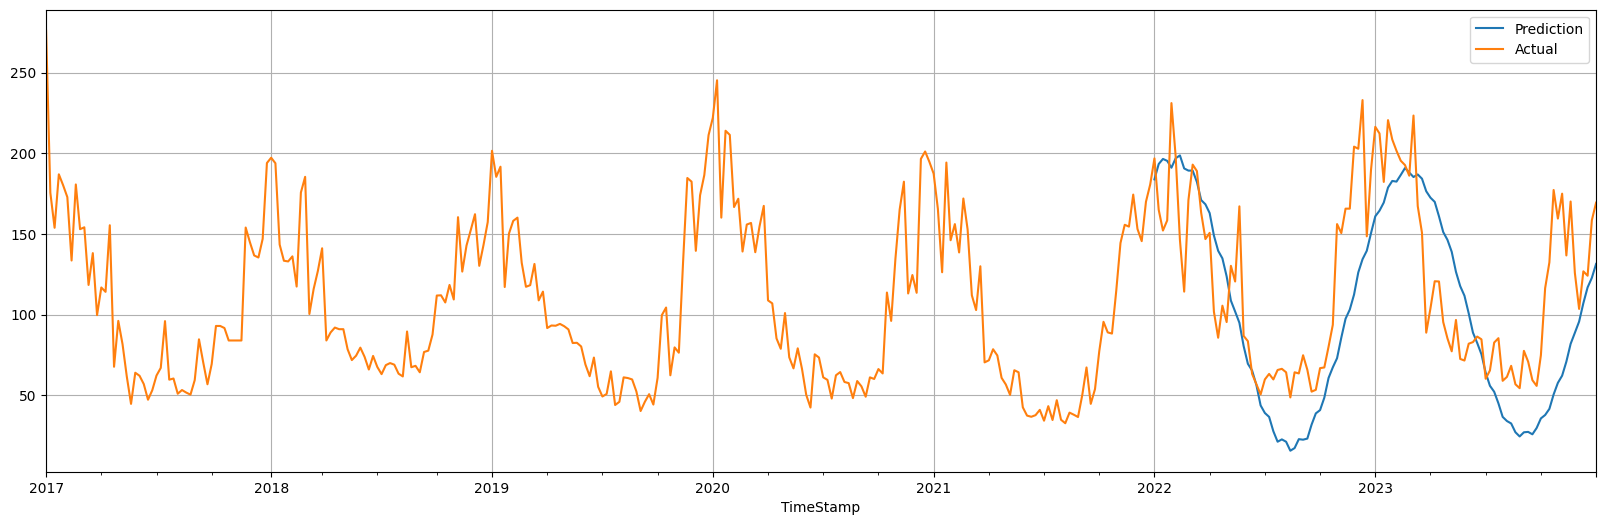

                               SARIMAX Results                                
Dep. Variable:                   WAQI   No. Observations:                  261
Model:                 ARIMA(9, 0, 8)   Log Likelihood               -1160.588
Date:                Fri, 26 Apr 2024   AIC                           2359.176
Time:                        08:50:46   BIC                           2426.902
Sample:                    01-01-2017   HQIC                          2386.400
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.3105      1.065     98.837      0.000     103.222     107.399
ar.L1          0.0516      0.839      0.062      0.951      -1.592       1.695
ar.L2          0.9344      0.765      1.221      0.2

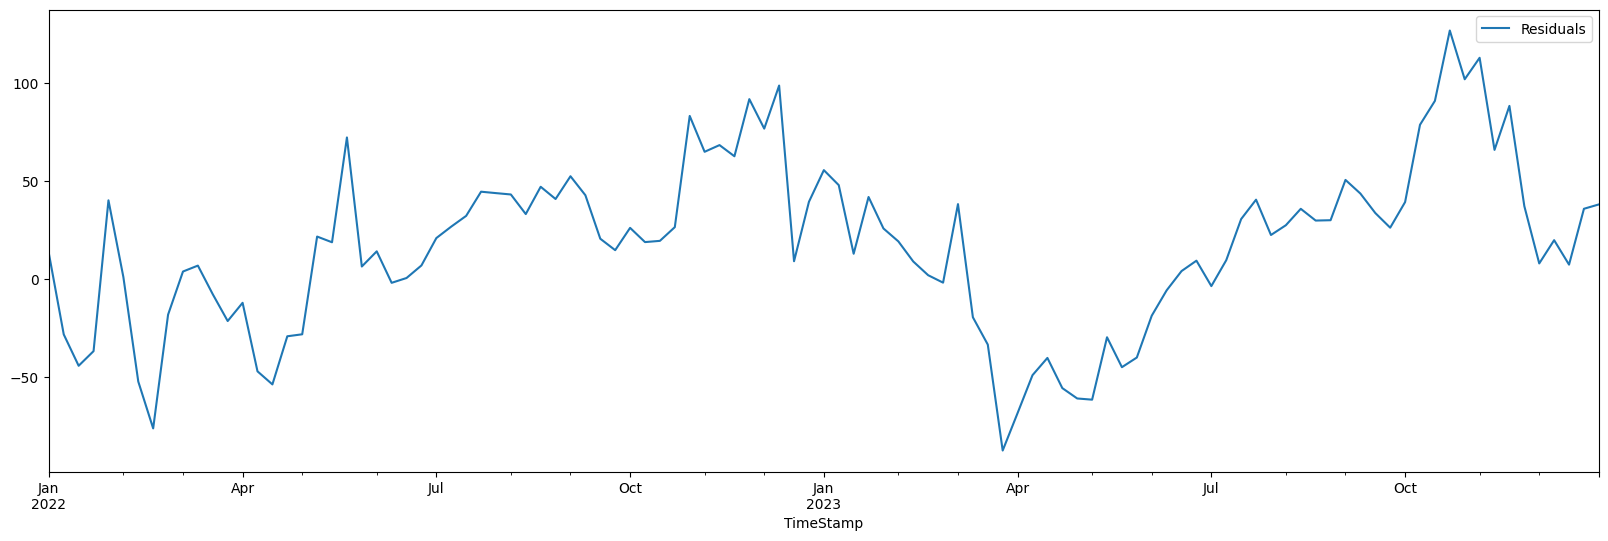

In [89]:
model_summary, residuals, prediction = train_test_arima_model(weekly_df, train_start_date, train_end_date, test_start_date, 9, 0, 8)

prediction.plot(figsize=(20, 6), label='Prediction')
weekly_df['WAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

In [90]:
metrics = model_evaluation(weekly_df[weekly_df.index >= test_start_date]['WAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

ARIMA_weekly = metrics

Mean Absolute Error: 37.39047232604165
Mean Squared Error: 2120.412288458724
Mean Absolute Percentage Error: 34.97032607702976
Root Mean Squared Error: 46.047934681793535


## SARIMA model with p = 0, d = 0, q = 0, P = 6, D = 1, Q = 7, S = 7

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71855D+00    |proj g|=  7.87070D-01


 This problem is unconstrained.



At iterate    5    f=  4.65304D+00    |proj g|=  2.81781D-01

At iterate   10    f=  4.59784D+00    |proj g|=  1.74308D-01

At iterate   15    f=  4.57468D+00    |proj g|=  2.52578D-01

At iterate   20    f=  4.57078D+00    |proj g|=  2.14999D-02

At iterate   25    f=  4.56971D+00    |proj g|=  3.45994D-02

At iterate   30    f=  4.56807D+00    |proj g|=  2.11347D-02

At iterate   35    f=  4.56648D+00    |proj g|=  1.03206D-01

At iterate   40    f=  4.56434D+00    |proj g|=  8.46910D-02

At iterate   45    f=  4.56357D+00    |proj g|=  9.01441D-03

At iterate   50    f=  4.56341D+00    |proj g|=  8.13749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


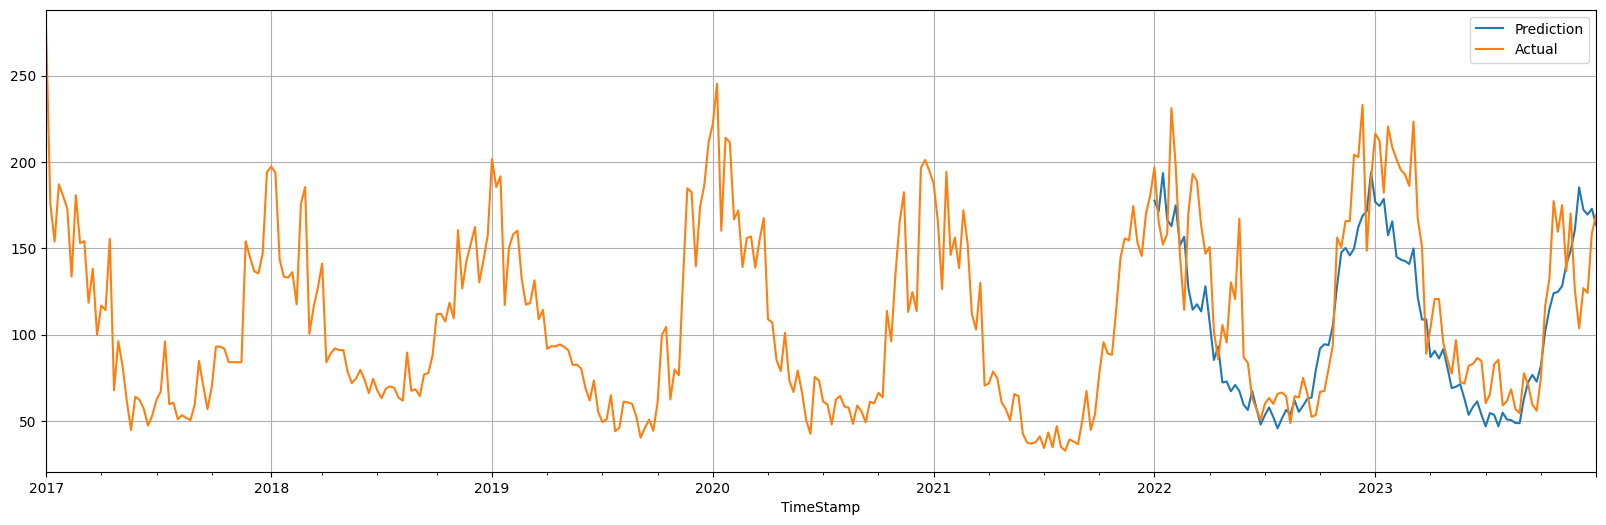

                                             SARIMAX Results                                             
Dep. Variable:                                              WAQI   No. Observations:                  261
Model:             SARIMAX(6, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9], 7)   Log Likelihood               -1191.050
Date:                                           Fri, 26 Apr 2024   AIC                           2414.100
Time:                                                   08:52:23   BIC                           2470.697
Sample:                                               01-01-2017   HQIC                          2436.868
                                                    - 12-26-2021                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

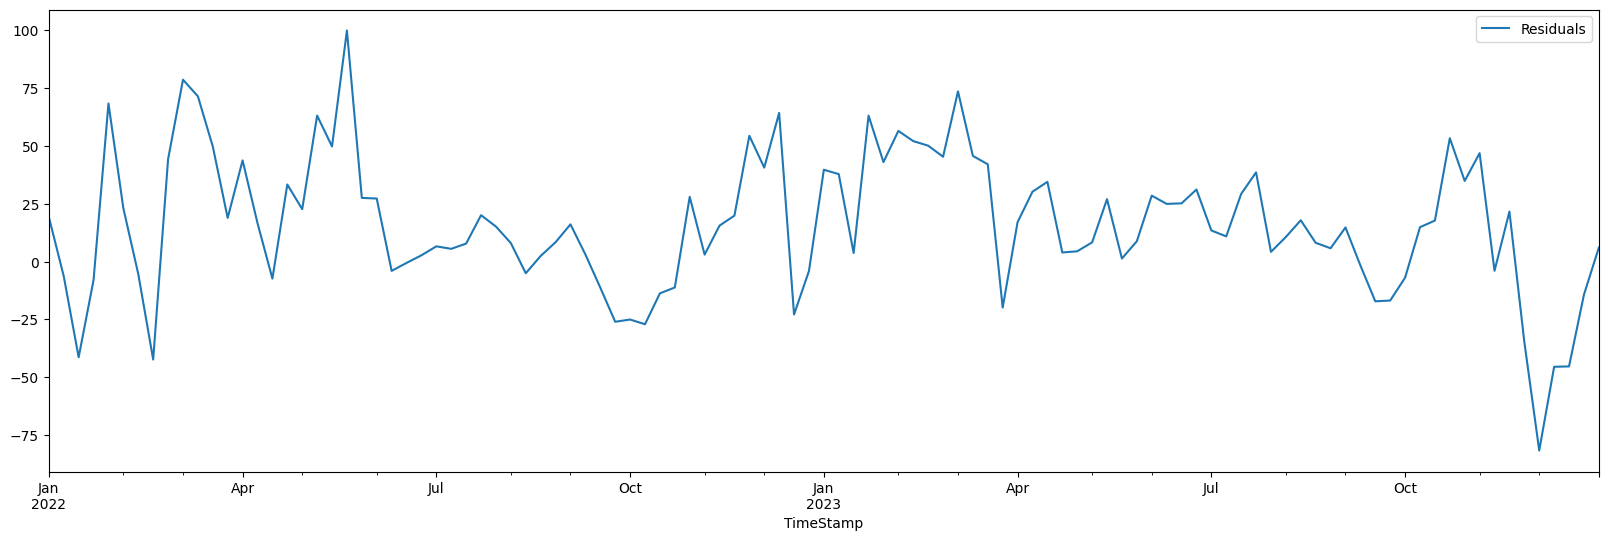

In [91]:
model_summary, residuals, prediction = train_test_SARIMAX_model(weekly_df, train_start_date, train_end_date, test_start_date, 0, 0, 0, 6, 1, 9, 7)

prediction.plot(figsize=(20, 6), label='Prediction')
weekly_df['WAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

In [92]:
metrics = model_evaluation(weekly_df[weekly_df.index >= test_start_date]['WAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

SARIMA_weekly_1 = metrics

Mean Absolute Error: 26.426328565679878
Mean Squared Error: 1146.11675835316
Mean Absolute Percentage Error: 21.28668337183429
Root Mean Squared Error: 33.85434622545767


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36912D+00    |proj g|=  5.64822D-01

At iterate    5    f=  5.06439D+00    |proj g|=  2.58398D-02

At iterate   10    f=  5.04397D+00    |proj g|=  1.27988D-02

At iterate   15    f=  5.03992D+00    |proj g|=  1.09841D-02

At iterate   20    f=  5.02552D+00    |proj g|=  9.33658D-02

At iterate   25    f=  4.95432D+00    |proj g|=  1.37258D+00

At iterate   30    f=  4.89000D+00    |proj g|=  8.77223D-01

At iterate   35    f=  4.82577D+00    |proj g|=  7.20610D-01

At iterate   40    f=  4.78062D+00    |proj g|=  1.43829D+00

At iterate   45    f=  4.72834D+00    |proj g|=  1.59890D+00


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.70861D+00    |proj g|=  1.73287D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     71      1     0     0   1.733D+00   4.709D+00
  F =   4.7086065006345228     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


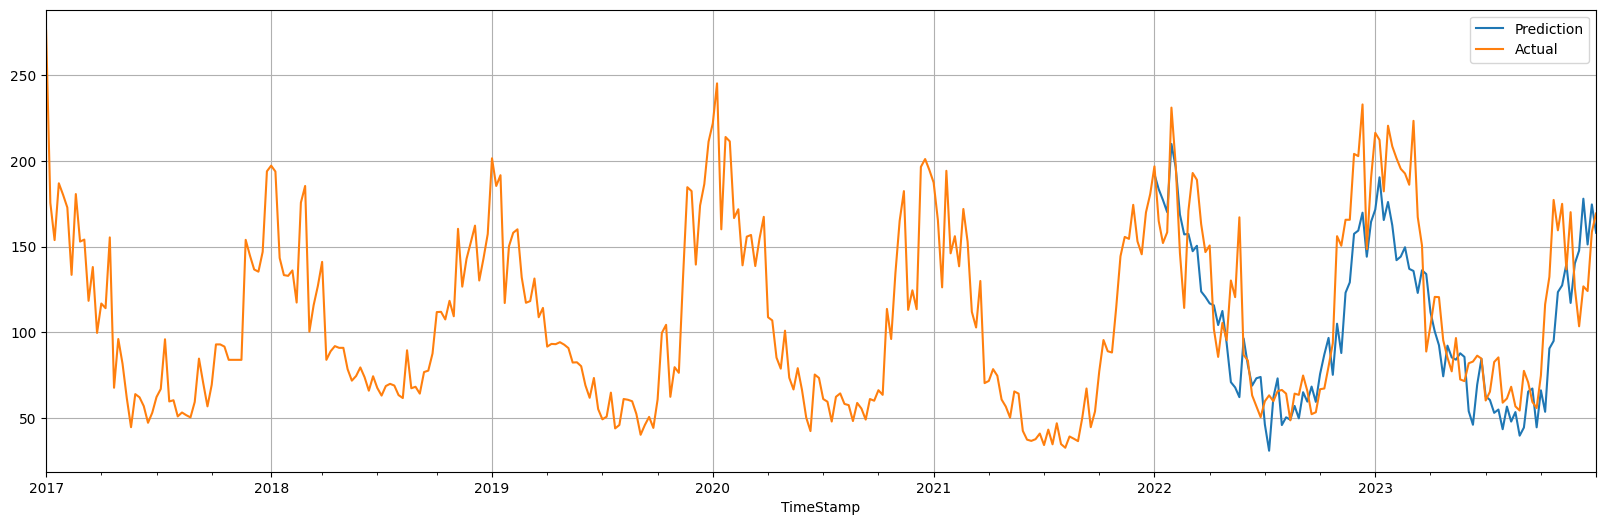

                                             SARIMAX Results                                              
Dep. Variable:                                               WAQI   No. Observations:                  261
Model:             SARIMAX(6, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9], 12)   Log Likelihood               -1228.946
Date:                                            Fri, 26 Apr 2024   AIC                           2489.893
Time:                                                    08:56:03   BIC                           2546.172
Sample:                                                01-01-2017   HQIC                          2512.546
                                                     - 12-26-2021                                         
Covariance Type:                                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

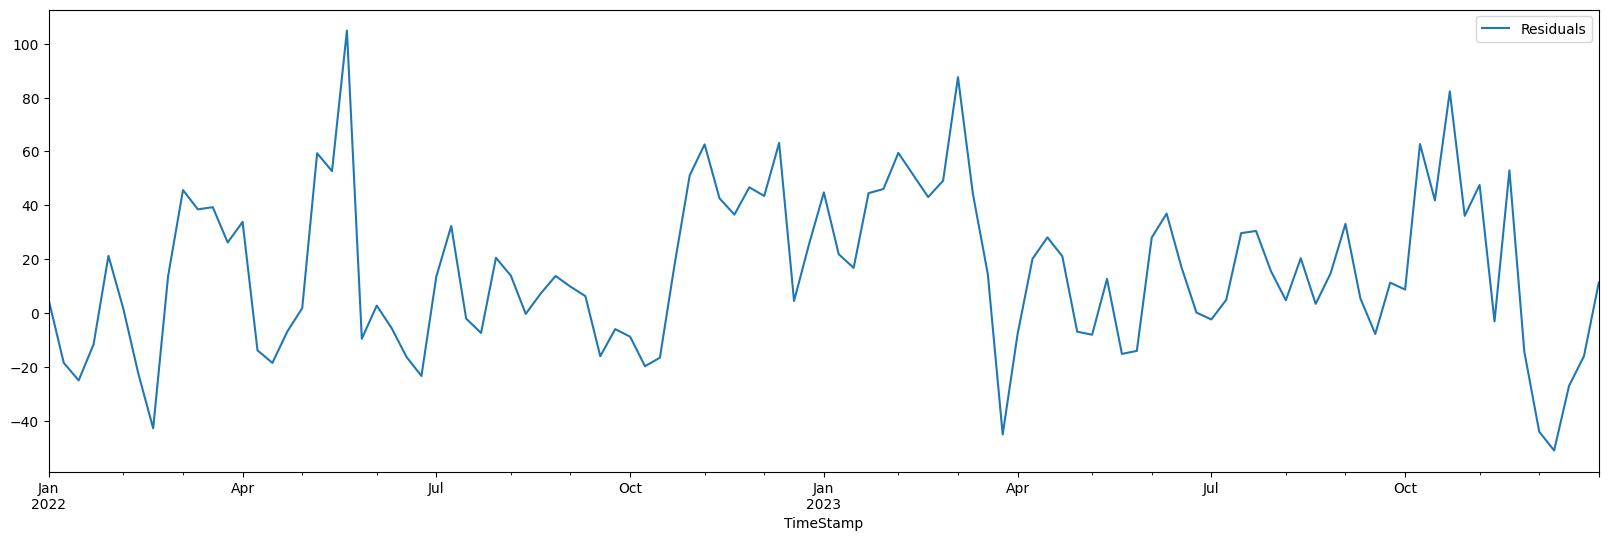

In [93]:
model_summary, residuals, prediction = train_test_SARIMAX_model(weekly_df, train_start_date, train_end_date, test_start_date, 0, 0, 0, 6, 1, 9, 12)

prediction.plot(figsize=(20, 6), label='Prediction')
weekly_df['WAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

In [94]:
metrics = model_evaluation(weekly_df[weekly_df.index >= test_start_date]['WAQI'], prediction.values)
print("Mean Absolute Error:", metrics[0])
print("Mean Squared Error:", metrics[1])
print("Mean Absolute Percentage Error:", metrics[2])
print("Root Mean Squared Error:", metrics[3])

SARIMA_weekly_2 = metrics

Mean Absolute Error: 25.868684028275304
Mean Squared Error: 1092.7921606663115
Mean Absolute Percentage Error: 21.124896155303123
Root Mean Squared Error: 33.057407046928404


In [ ]:
model_summary, residuals, prediction = train_test_SARIMAX_model(weekly_df, train_start_date, train_end_date, test_start_date, 0, 0, 0, 6, 1, 9, 52)


In [ ]:
prediction.plot(figsize=(20, 6), label='Prediction')
weekly_df['WAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62804D+00    |proj g|=  2.51481D-01

At iterate    5    f=  4.51603D+00    |proj g|=  2.61530D-02

At iterate   10    f=  4.50626D+00    |proj g|=  2.85332D-02

At iterate   15    f=  4.48586D+00    |proj g|=  2.96552D-02

At iterate   20    f=  4.47190D+00    |proj g|=  1.46141D-01

At iterate   25    f=  4.46130D+00    |proj g|=  2.57061D-02

At iterate   30    f=  4.45496D+00    |proj g|=  2.02330D-02

At iterate   35    f=  4.45031D+00    |proj g|=  3.48336D-02

At iterate   40    f=  4.44371D+00    |proj g|=  2.59657D-02

At iterate   45    f=  4.44125D+00    |proj g|=  1.39620D-02

At iterate   50    f=  4.43972D+00    |proj g|=  2.08391D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


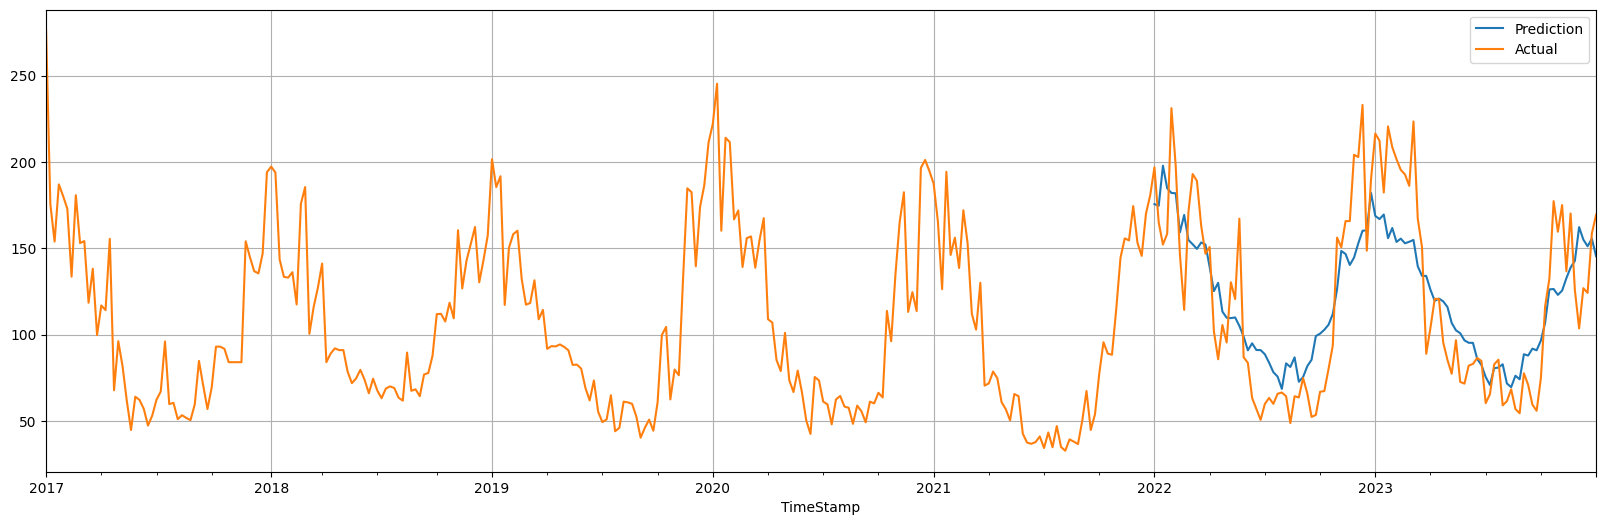

                                                  SARIMAX Results                                                  
Dep. Variable:                                                        WAQI   No. Observations:                  261
Model:             SARIMAX(4, 0, 2)x(6, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9], 7)   Log Likelihood               -1158.767
Date:                                                     Sun, 21 Apr 2024   AIC                           2361.534
Time:                                                             06:03:55   BIC                           2439.355
Sample:                                                         01-01-2017   HQIC                          2392.840
                                                              - 12-26-2021                                         
Covariance Type:                                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      

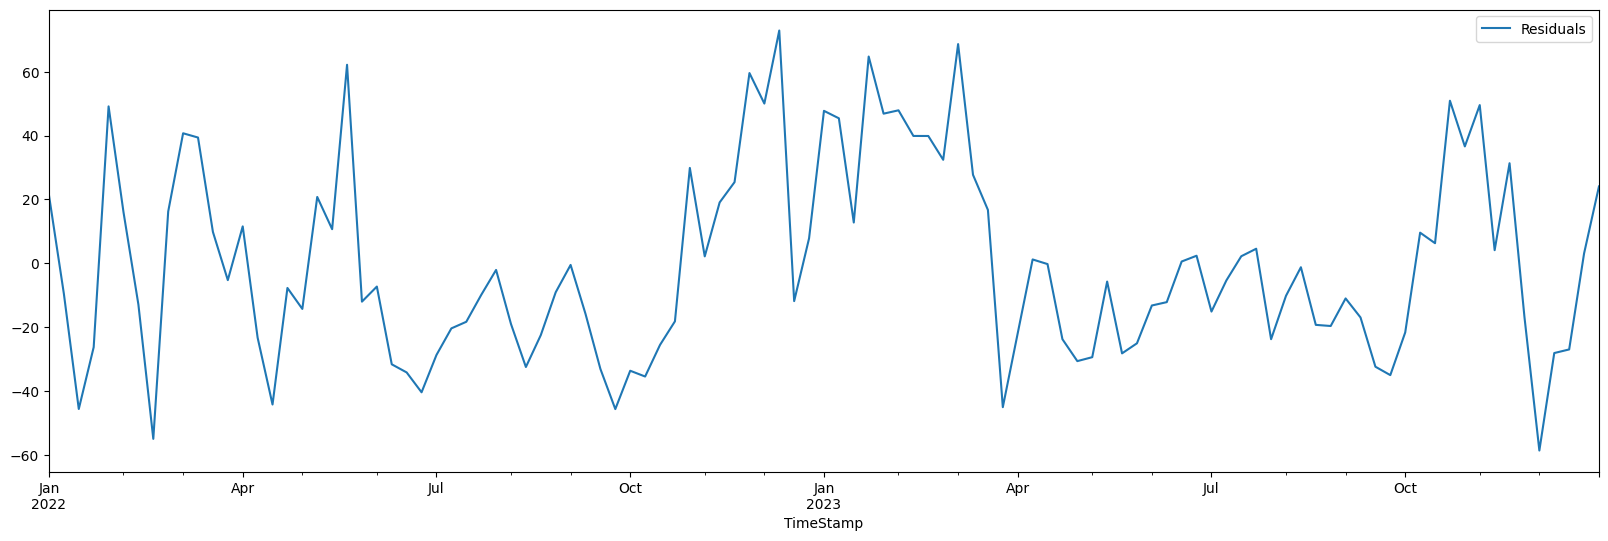

In [36]:
model_summary, residuals, prediction = train_test_SARIMAX_model(weekly_df, train_start_date, train_end_date, test_start_date, 4, 0, 2, 6, 1, 9, 7)

prediction.plot(figsize=(20, 6), label='Prediction')
weekly_df['WAQI'].plot(figsize=(20, 6), label='Actual')
plt.legend()
plt.grid(True)
plt.show()

print(model_summary)

residuals.plot(figsize=(20, 6), label='Residual')
plt.show()